In [ ]:
from ember import Config, Paths, InitialCondition, StrainParameters, General, Times, TerminationCondition, ConcreteConfig, General, Debug, \
  CvodeTolerances, Chemistry, QssTolerances, QssTolerances
import matplotlib.pyplot as plt
import numpy as np
import cantera as ct
import os
import time
from ember import _ember
from inference import RLSolverSelector

In [ ]:
def set_integrator_rl(solver, rl_selector, decision_step, super_steps=100, total_time=0.02, pressure=101325):
    """
    Set integrator type using RL agent.
    
    Args:
        solver: Ember solver instance
        rl_selector: RLSolverSelector instance
        decision_step: Current decision step (increments every super_steps timesteps)
        super_steps: Number of timesteps per RL decision (should match training)
    """
    nPoints = len(solver.T)
    
    # Map RL actions to integrator names
    action_to_integrator = {0: 'cvode', 1: 'qss'}
    
    # Update RL selector with current simulation time
    current_time = decision_step * super_steps * 1e-6  # Assuming dt = 1e-6
    rl_selector.update_simulation_params(current_time, total_time, pressure)  
    
    try:
        temperatures = np.asarray(solver.T, dtype=np.float32)
        species_batch = np.asarray(solver.Y, dtype=np.float32).transpose(1,0)
        actions, confidences = rl_selector.select_solver_batch(temperatures, species_batch, deterministic=True)
        integ_types = [action_to_integrator.get(a, 'cvode') for a in actions]
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"RL batch selection failed: {e}")
        integ_types = ['cvode'] * nPoints
    
    return integ_types

def set_integrator_heuristic(solver, constant_int=None):
    """
    Original heuristic integrator selection (for comparison)
    """
    nPoints = len(solver.T)
    
    # Start with temperature-based decision
    integ = np.where(solver.T <= 600.0, 'qss', 'cvode')
    
    try:
        # Get equivalence ratio
        phi = solver.phi
        
        # Use qss for problematic phi regions
        integ = np.where(phi == -1, 'qss', integ)  # invalid phi
        integ = np.where(phi <= 1e-8, 'qss', integ)  # oxidizer-dominated
        integ = np.where(phi >= 1e4, 'qss', integ)   # fuel-dominated
        
        # Create boolean mask for CVODE points
        cvode_mask = (integ == 'cvode')
        
        # Shift masks to check neighbors
        cvode_mask_left = np.roll(cvode_mask, 1)
        cvode_mask_right = np.roll(cvode_mask, -1)
        
        # Fix boundary conditions
        cvode_mask_left[0] = False
        cvode_mask_right[-1] = False
        
        # If either neighbor is CVODE, use CVODE
        use_cvode = cvode_mask | cvode_mask_left | cvode_mask_right
        integ = np.where(use_cvode, 'cvode', 'qss')
        
    except Exception as e:
        print(f"Warning: Could not calculate phi for integrator selection: {e}")
        pass
    
    # Convert to list
    integ = integ.tolist()
    
    # Override with constant integrator if specified
    if constant_int:
        integ = [constant_int] * nPoints
    
    return integ


In [ ]:
integrator_method = 'rl'
t_end = 0.002
Tfuel = 300
Toxidizer = 1200
centerWidth = 0.0
slopeWidth = 0.0
xLeft = -0.02
xRight = 0.02
pressure = 101325
dt = 1e-6

total_steps = int(t_end / dt)
print(f"Total steps: {total_steps}")

fuel_info = [
    {
        'mechanism_file': "large_mechanism/n-dodecane.yaml",
        'fuel': 'nc12h26:1.0',
        'oxidizer': 'n2:3.76, o2:1.0',
    },
    {
        'mechanism_file': 'large_mechanism/ch4_53species.yaml',
        'fuel': 'CH4:1.0',
        'oxidizer': 'O2:1.0, N2:3.76',
    },
]

choice = 0  # Using n-dodecane for testing
fuel = fuel_info[choice]['fuel']
oxidizer = fuel_info[choice]['oxidizer']
mechanism_file = fuel_info[choice]['mechanism_file']

npoints = 100
output_dir = f'run/ex_diffusion_{integrator_method}'

conf = Config(
    Paths(outputDir=output_dir),
    General(nThreads=1, chemistryIntegrator='cvode'),
    Chemistry(mechanismFile=mechanism_file),
    InitialCondition(Tfuel=Tfuel, Toxidizer=Toxidizer, centerWidth=centerWidth,
                    equilibrateCounterflow=False, flameType='diffusion',
                    slopeWidth=slopeWidth, xLeft=xLeft, pressure=pressure,
                    xRight=xRight, nPoints=npoints, fuel=fuel, oxidizer=oxidizer),
    StrainParameters(final=100, initial=100),
    Times(globalTimestep=dt, profileStepInterval=20),  # dt = 1e-6
    TerminationCondition(abstol=0.0, dTdtTol=0, steadyPeriod=1.0,
                        tEnd=t_end, tolerance=0.0),
    QssTolerances(abstol=1e-11, dtmin=1e-16, dtmax=1e-6,
                    epsmin=2e-2, epsmax=1e1, iterationCount=2,
                    stabilityCheck=False),
    CvodeTolerances(relativeTolerance=1e-9, momentumAbsTol=1e-12,
                    energyAbsTol=1e-12, speciesAbsTol=1e-12,
                    minimumTimestep=1e-18, maximumTimestep=1e-5),
    Debug(veryVerbose=False),
)

conf = ConcreteConfig(conf)

# Create output directory
if not os.path.isdir(conf.paths.outputDir):
    os.makedirs(conf.paths.outputDir, 0o0755)

In [ ]:
# Initialize RL selector if needed
model_path = "logs/models/model_update_40.pt" 
rl_selector = None
if integrator_method == 'rl':
    if model_path is None:
        raise ValueError("model_path is required for RL method")
    rl_selector = RLSolverSelector(model_path, mechanism_file)
    rl_selector.reset_state()

print(f"Starting simulation with {integrator_method} method")
# Run simulation
solver = _ember.FlameSolver(conf)
solver.initialize()
done = False
initial_T = solver.T.copy()
initial_Y = solver.Y.copy()
cpu_time_list = []
integrator_types_history = []
decision_step = 0
timestep_count = 0
super_steps = 100

In [ ]:
integrator_type_list = set_integrator_rl(solver, rl_selector, decision_step, super_steps)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), dpi=100)
ax1.plot(solver.T)
ax2.plot(solver.Y)
plt.show()

In [ ]:
solver.phi

In [ ]:
print(temperatures.shape)
print(species_batch.shape)

In [ ]:
def run_simulation_with_method(integrator_method='rl', model_path=None, super_steps=100):
    """
    Run simulation with specified integrator selection method
    
    Args:
        integrator_method: 'rl', 'cvode', 'qss', or 'heuristic'
        model_path: Path to RL model (required if method='rl')
        super_steps: Number of timesteps per RL decision
    """
    # Configuration setup (using your existing config)
    fuel_info = [
        {
            'mechanism_file': "large_mechanism/n-dodecane.yaml",
            'fuel': 'nc12h26:1.0',
            'oxidizer': 'n2:3.76, o2:1.0',
        },
        {
            'mechanism_file': 'large_mechanism/ch4_53species.yaml',
            'fuel': 'CH4:1.0',
            'oxidizer': 'O2:1.0, N2:3.76',
        },
    ]
    
    choice = 0  # Using n-dodecane for testing
    fuel = fuel_info[choice]['fuel']
    oxidizer = fuel_info[choice]['oxidizer']
    mechanism_file = fuel_info[choice]['mechanism_file']
    
    npoints = 100
    output_dir = f'run/ex_diffusion_{integrator_method}'
    
    conf = Config(
        Paths(outputDir=output_dir),
        General(nThreads=1, chemistryIntegrator='cvode'),
        Chemistry(mechanismFile=mechanism_file),
        InitialCondition(Tfuel=300, Toxidizer=1200, centerWidth=0.0,
                        equilibrateCounterflow=False, flameType='diffusion',
                        slopeWidth=0.0, xLeft=-0.02, pressure=101325,
                        xRight=0.02, nPoints=npoints, fuel=fuel, oxidizer=oxidizer),
        StrainParameters(final=100, initial=100),
        Times(globalTimestep=1e-06, profileStepInterval=20),  # dt = 1e-6
        TerminationCondition(abstol=0.0, dTdtTol=0, steadyPeriod=1.0,
                           tEnd=0.02, tolerance=0.0),
        QssTolerances(abstol=1e-11, dtmin=1e-16, dtmax=1e-6,
                     epsmin=2e-2, epsmax=1e1, iterationCount=2,
                     stabilityCheck=False),
        CvodeTolerances(relativeTolerance=1e-9, momentumAbsTol=1e-12,
                       energyAbsTol=1e-12, speciesAbsTol=1e-12,
                       minimumTimestep=1e-18, maximumTimestep=1e-5),
        Debug(veryVerbose=False),
    )
    
    conf = ConcreteConfig(conf)
    
    # Create output directory
    if not os.path.isdir(conf.paths.outputDir):
        os.makedirs(conf.paths.outputDir, 0o0755)
    
    # Initialize RL selector if needed
    rl_selector = None
    if integrator_method == 'rl':
        if model_path is None:
            raise ValueError("model_path is required for RL method")
        rl_selector = RLSolverSelector(model_path, mechanism_file)
        rl_selector.reset_state()
    
    print(f"Starting simulation with {integrator_method} method")
    # Run simulation
    solver = _ember.FlameSolver(conf)
    solver.initialize()
    done = False
    initial_T = solver.T.copy()
    cpu_time_list = []
    integrator_types_history = []
    decision_step = 0
    timestep_count = 0
    
    count = 0
    while not done:
        print(f"Iteration {count} (Decision step: {decision_step}) - timestep {timestep_count}")
        
        # Select integrator method
        if integrator_method == 'rl':
            # Make RL decision every super_steps timesteps
            if timestep_count % super_steps == 0:
                integrator_type_list = set_integrator_rl(solver, rl_selector, decision_step, super_steps)
                decision_step += 1
            # Use the same decision for super_steps timesteps
            solver.set_integrator_types(integrator_type_list)
            
        elif integrator_method == 'heuristic':
            integrator_type_list = set_integrator_heuristic(solver)
            solver.set_integrator_types(integrator_type_list)
            
        elif integrator_method in ['cvode', 'qss']:
            solver.set_integrator_types([integrator_method] * npoints)
            integrator_type_list = [integrator_method] * npoints
        
        start_time = time.time()
        done = solver.step()
        time_taken = time.time() - start_time
        
        cpu_time_list.append(np.sum(solver.gridPointIntegrationTimes))
        integrator_types_history.append(integrator_type_list.copy())
        
        timestep_count += 1
        
        if count % 500 == 0:
            print(f"Count: {count}, Max Temperature: {solver.T.max():.1f}K, Time taken: {time_taken:.4f}s")
            if integrator_method in ['rl', 'heuristic']:
                cvode_count = integrator_type_list.count('cvode')
                qss_count = integrator_type_list.count('qss')
                print(f"  CVODE points: {cvode_count}, QSS points: {qss_count}")
        
        count += 1
    
    return solver.T, initial_T, cpu_time_list, integrator_types_history


In [ ]:
class RLSolverSelector:
    """Lightweight RL policy inference for CFD integration"""
    
    def __init__(self, model_path, mechanism_file, 
                 solver_configs=None, device='cpu'):
        """
        Initialize the RL solver selector
        
        Args:
            model_path: Path to saved PyTorch model (.pt file)
            mechanism_file: Path to Cantera mechanism file
            solver_configs: List of solver configurations (optional, for name mapping)
            device: 'cpu' or 'cuda'
        """
        self.device = device
        self.mechanism_file = mechanism_file
        
        # Load Cantera gas object
        self.gas = ct.Solution(mechanism_file)
        
        # Key species for observation (same as training)
        self.key_species = ['O','H','OH','H2O','O2','H2','H2O2','N2']
        self.key_species_indices = np.array([self.gas.species_index(spec) for spec in self.key_species])
        
        # Load model
        checkpoint = torch.load(model_path, map_location=device)
        
        # Extract observation normalization parameters
        self.obs_mean = torch.tensor(checkpoint['obs_mean'], dtype=torch.float32, device=device)
        self.obs_var = torch.tensor(checkpoint['obs_var'], dtype=torch.float32, device=device)
        self.obs_std = torch.sqrt(self.obs_var + 1e-8)
        
        # Initialize network
        obs_dim = len(self.obs_mean)
        if solver_configs is None:
            # Default solver configs (adjust based on your setup)
            action_dim = 2  # Adjust this based on your number of solvers
        else:
            action_dim = len(solver_configs)
            
        self.network = PPONetwork(obs_dim, action_dim)
        self.network.load_state_dict(checkpoint['model_state_dict'])
        self.network.eval()
        self.network.to(device)
        
        # Store solver configs for name mapping
        self.solver_configs = solver_configs
        
        # Initialize state tracking for trend features
        self.last_obs = None
        
        # Simulation parameters (you may need to adjust these)
        self.current_time = 0.0
        self.total_time = 1e-2  # Default, update as needed
        self.current_pressure = 1.0 * ct.one_atm  # Default pressure
        
        print(f"RL Solver Selector initialized with {action_dim} solvers on {device}")
    
    def update_simulation_params(self, current_time, total_time, pressure):
        """Update simulation parameters for accurate observation calculation"""
        self.current_time = current_time
        self.total_time = total_time
        self.current_pressure = pressure
    
    def reset_state(self):
        """Reset internal state (call at start of new simulation)"""
        self.last_obs = None
        self.current_time = 0.0
    
    def _get_observation(self, temperature, species_fractions):
        """
        Convert temperature and species to normalized observation
        
        Args:
            temperature: Temperature in K
            species_fractions: Mass fractions array (same order as gas.species_names)
        
        Returns:
            Normalized observation tensor
        """
        # Update gas state for species lookup
        self.gas.TPY = temperature, self.current_pressure, species_fractions
        
        # Key species (log10 mole fractions)
        key_vals = []
        for spec in self.key_species:
            try:
                idx = self.gas.species_index(spec)
                key_vals.append(species_fractions[idx])
            except ValueError:
                key_vals.append(0.0)
        
        # Base features (same as training)
        temp_norm = (temperature - 300.0) / 2000.0
        species_log = np.log10(np.maximum(key_vals, 1e-20))
        pressure_log = np.log10(self.current_pressure / ct.one_atm)
        
        # Time-left feature
        time_left = max(0.0, self.total_time - self.current_time)
        time_left_norm = np.clip(time_left / (self.total_time + 1e-12), 0.0, 1.0)
        
        # Base observation
        base_obs = np.hstack([temp_norm, species_log, pressure_log, time_left_norm]).astype(np.float32)
        
        # Trend features (delta from last observation)
        if self.last_obs is None:
            trend = np.zeros_like(base_obs, dtype=np.float32)
        else:
            trend = base_obs - self.last_obs
        
        # Combined observation
        obs = np.hstack([base_obs, trend]).astype(np.float32)
        self.last_obs = base_obs.copy()
        
        return obs
    
    def _normalize_observation(self, obs):
        """Apply observation normalization (same as training)"""
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=self.device)
        normalized = (obs_tensor - self.obs_mean) / self.obs_std
        return normalized.unsqueeze(0)  # Add batch dimension
    
    @torch.no_grad()
    def select_solver(self, temperature, species_fractions, deterministic=True):
        """
        Select solver based on current state
        
        Args:
            temperature: Temperature in K
            species_fractions: Mass fractions array
            deterministic: If True, use argmax; if False, sample from distribution
        
        Returns:
            action (int): Solver index
            confidence (float): Confidence/probability of selected action
        """
        # Get observation
        obs = self._get_observation(temperature, species_fractions)
        
        # Normalize observation
        obs_normalized = self._normalize_observation(obs)
        
        # Forward pass
        logits, _ = self.network(obs_normalized)
        
        if deterministic:
            # Use most probable action
            action = torch.argmax(logits, dim=1).item()
            # Get softmax probabilities for confidence
            probs = torch.softmax(logits, dim=1)
            confidence = probs[0, action].item()
        else:
            # Sample from distribution
            dist = Categorical(logits=logits)
            action = dist.sample().item()
            confidence = torch.exp(dist.log_prob(torch.tensor([action]))).item()
        
        return action, confidence
    
    def get_solver_name(self, action):
        """Get solver name from action index"""
        if self.solver_configs and action < len(self.solver_configs):
            return self.solver_configs[action]['name']
        else:
            return f"Solver_{action}"
    
    def __call__(self, temperature, species_fractions, deterministic=True):
        """
        Convenient callable interface
        
        Args:
            temperature: Temperature in K
            species_fractions: Mass fractions array
            deterministic: Whether to use deterministic action selection
        
        Returns:
            action (int): Selected solver index
        """
        action, _ = self.select_solver(temperature, species_fractions, deterministic)
        return action

In [ ]:
# Usage example and utility functions
def load_rl_selector(model_path, mechanism_file, **kwargs):
    """
    Convenience function to load RL selector
    
    Args:
        model_path: Path to saved model
        mechanism_file: Path to mechanism file
        **kwargs: Additional arguments for RLSolverSelector
    
    Returns:
        RLSolverSelector instance
    """
    return RLSolverSelector(model_path, mechanism_file, **kwargs)

# Example integration with CFD solver
def integrate_timestep_with_rl(rl_selector, temperature, species_fractions, 
                              solvers_dict, dt, **solver_kwargs):
    """
    Example function showing how to integrate RL selection with CFD timestep
    
    Args:
        rl_selector: RLSolverSelector instance
        temperature: Current temperature
        species_fractions: Current species mass fractions
        solvers_dict: Dictionary mapping action indices to solver instances
        dt: Timestep size
        **solver_kwargs: Additional arguments for solver
    
    Returns:
        new_state: Updated state after integration
        action: Selected solver action
        success: Whether integration succeeded
    """
    # Select solver using RL policy
    action, confidence = rl_selector.select_solver(temperature, species_fractions)
    
    # Get corresponding solver
    solver = solvers_dict.get(action)
    
    if solver is None:
        return None, action, False
    
    try:
        # Integrate using selected solver
        # (This is pseudo-code - adjust based on your solver interface)
        new_state = solver.integrate(temperature, species_fractions, dt, **solver_kwargs)
        return new_state, action, True
    except Exception as e:
        print(f"Solver {action} failed: {e}")
        return None, action, False

In [ ]:


if __name__ == "__main__":
    # Example usage
    model_path = "logs/models/model_update_40.pt"
    mechanism_file = "large_mechanism/n-dodecane.yaml"
    
    # Define solver configurations (match your training setup)
    solver_configs = [
        {'name': 'CVODE_BDF', 'type': 'cvode'},
        {'name': 'QSS', 'type': 'qss'},
    ]
    
    # Initialize RL selector
    rl_selector = RLSolverSelector(
        model_path=model_path,
        mechanism_file=mechanism_file,
        solver_configs=solver_configs,
        device='cpu'  # Use 'cuda' if available and model was trained on GPU
    )
    
    # Update simulation parameters
    rl_selector.update_simulation_params(
        current_time=0.001,    # 1 ms into simulation
        total_time=0.01,       # 10 ms total simulation time
        pressure=5.0 * ct.one_atm  # 5 atm pressure
    )
    
    # Example state
    temperature = 1200.0  # K
    phi = 0.5
    gas = rl_selector.gas
    gas.set_equivalence_ratio(phi, 'nc12h26', 'O2:1, N2:3.76')
    species_fractions = gas.Y
    
    
    action, confidence = rl_selector.select_solver(temperature, species_fractions)
    
    print(f"Selected solver: {rl_selector.get_solver_name(action)} (action {action})")
    print(f"Confidence: {confidence:.3f}")
    
    # Or use callable interface
    action = rl_selector(temperature, species_fractions)
    print(f"Quick selection: {action}")
    
    gas.equilibrate('HP')
    species_fractions = gas.Y
    # Select solver
    
    action, confidence = rl_selector.select_solver(temperature, species_fractions)
    
    print(f"Selected solver: {rl_selector.get_solver_name(action)} (action {action})")
    print(f"Confidence: {confidence:.3f}")
    
    # Or use callable interface
    action = rl_selector(temperature, species_fractions)
    print(f"Quick selection: {action}")

In [ ]:
chkpt = torch.load(model_path, map_location='cpu', weights_only=False)


In [ ]:
key_species_indices = np.array([rl_selector.gas.species_index(spec) for spec in rl_selector.key_species])
key_species_names = np.array(rl_selector.key_species)
key_species_values = species_fractions[key_species_indices]

In [ ]:
print(key_species_indices)
print(key_species_names)
print(key_species_values)

In [ ]:
temperature = 1200.0  # K
phi = 0.5
gas = rl_selector.gas
gas.set_equivalence_ratio(phi, 'nc12h26', 'O2:1, N2:3.76')
species_fractions = gas.Y

In [ ]:
gas.equilibrate('HP')
species_fractions = gas.Y

In [ ]:
rl_selector.gas.species_names

## DATA ANALYSIS

In [116]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
with open('results_1D_300_900_6079500__0__0.002__1000.pkl', 'rb') as f:
    results = pickle.load(f)
import cantera as ct


In [117]:
methods = results.keys()

print(methods)

dict_keys(['rl', 'qss', 'cvode'])


In [118]:
rl_data = results['rl']
rl_data.keys()

T_history = np.array(rl_data['T_history'])
Y_history = np.array(rl_data['Y_history'])
integrator_history = np.array(rl_data['integrator_history'])



print(T_history.shape)
print(Y_history.shape)
print(integrator_history.shape)








(400, 500)
(400, 106, 500)
(400, 500)


In [119]:
rl_data['mean_cpu_time']

np.float64(0.30647229)

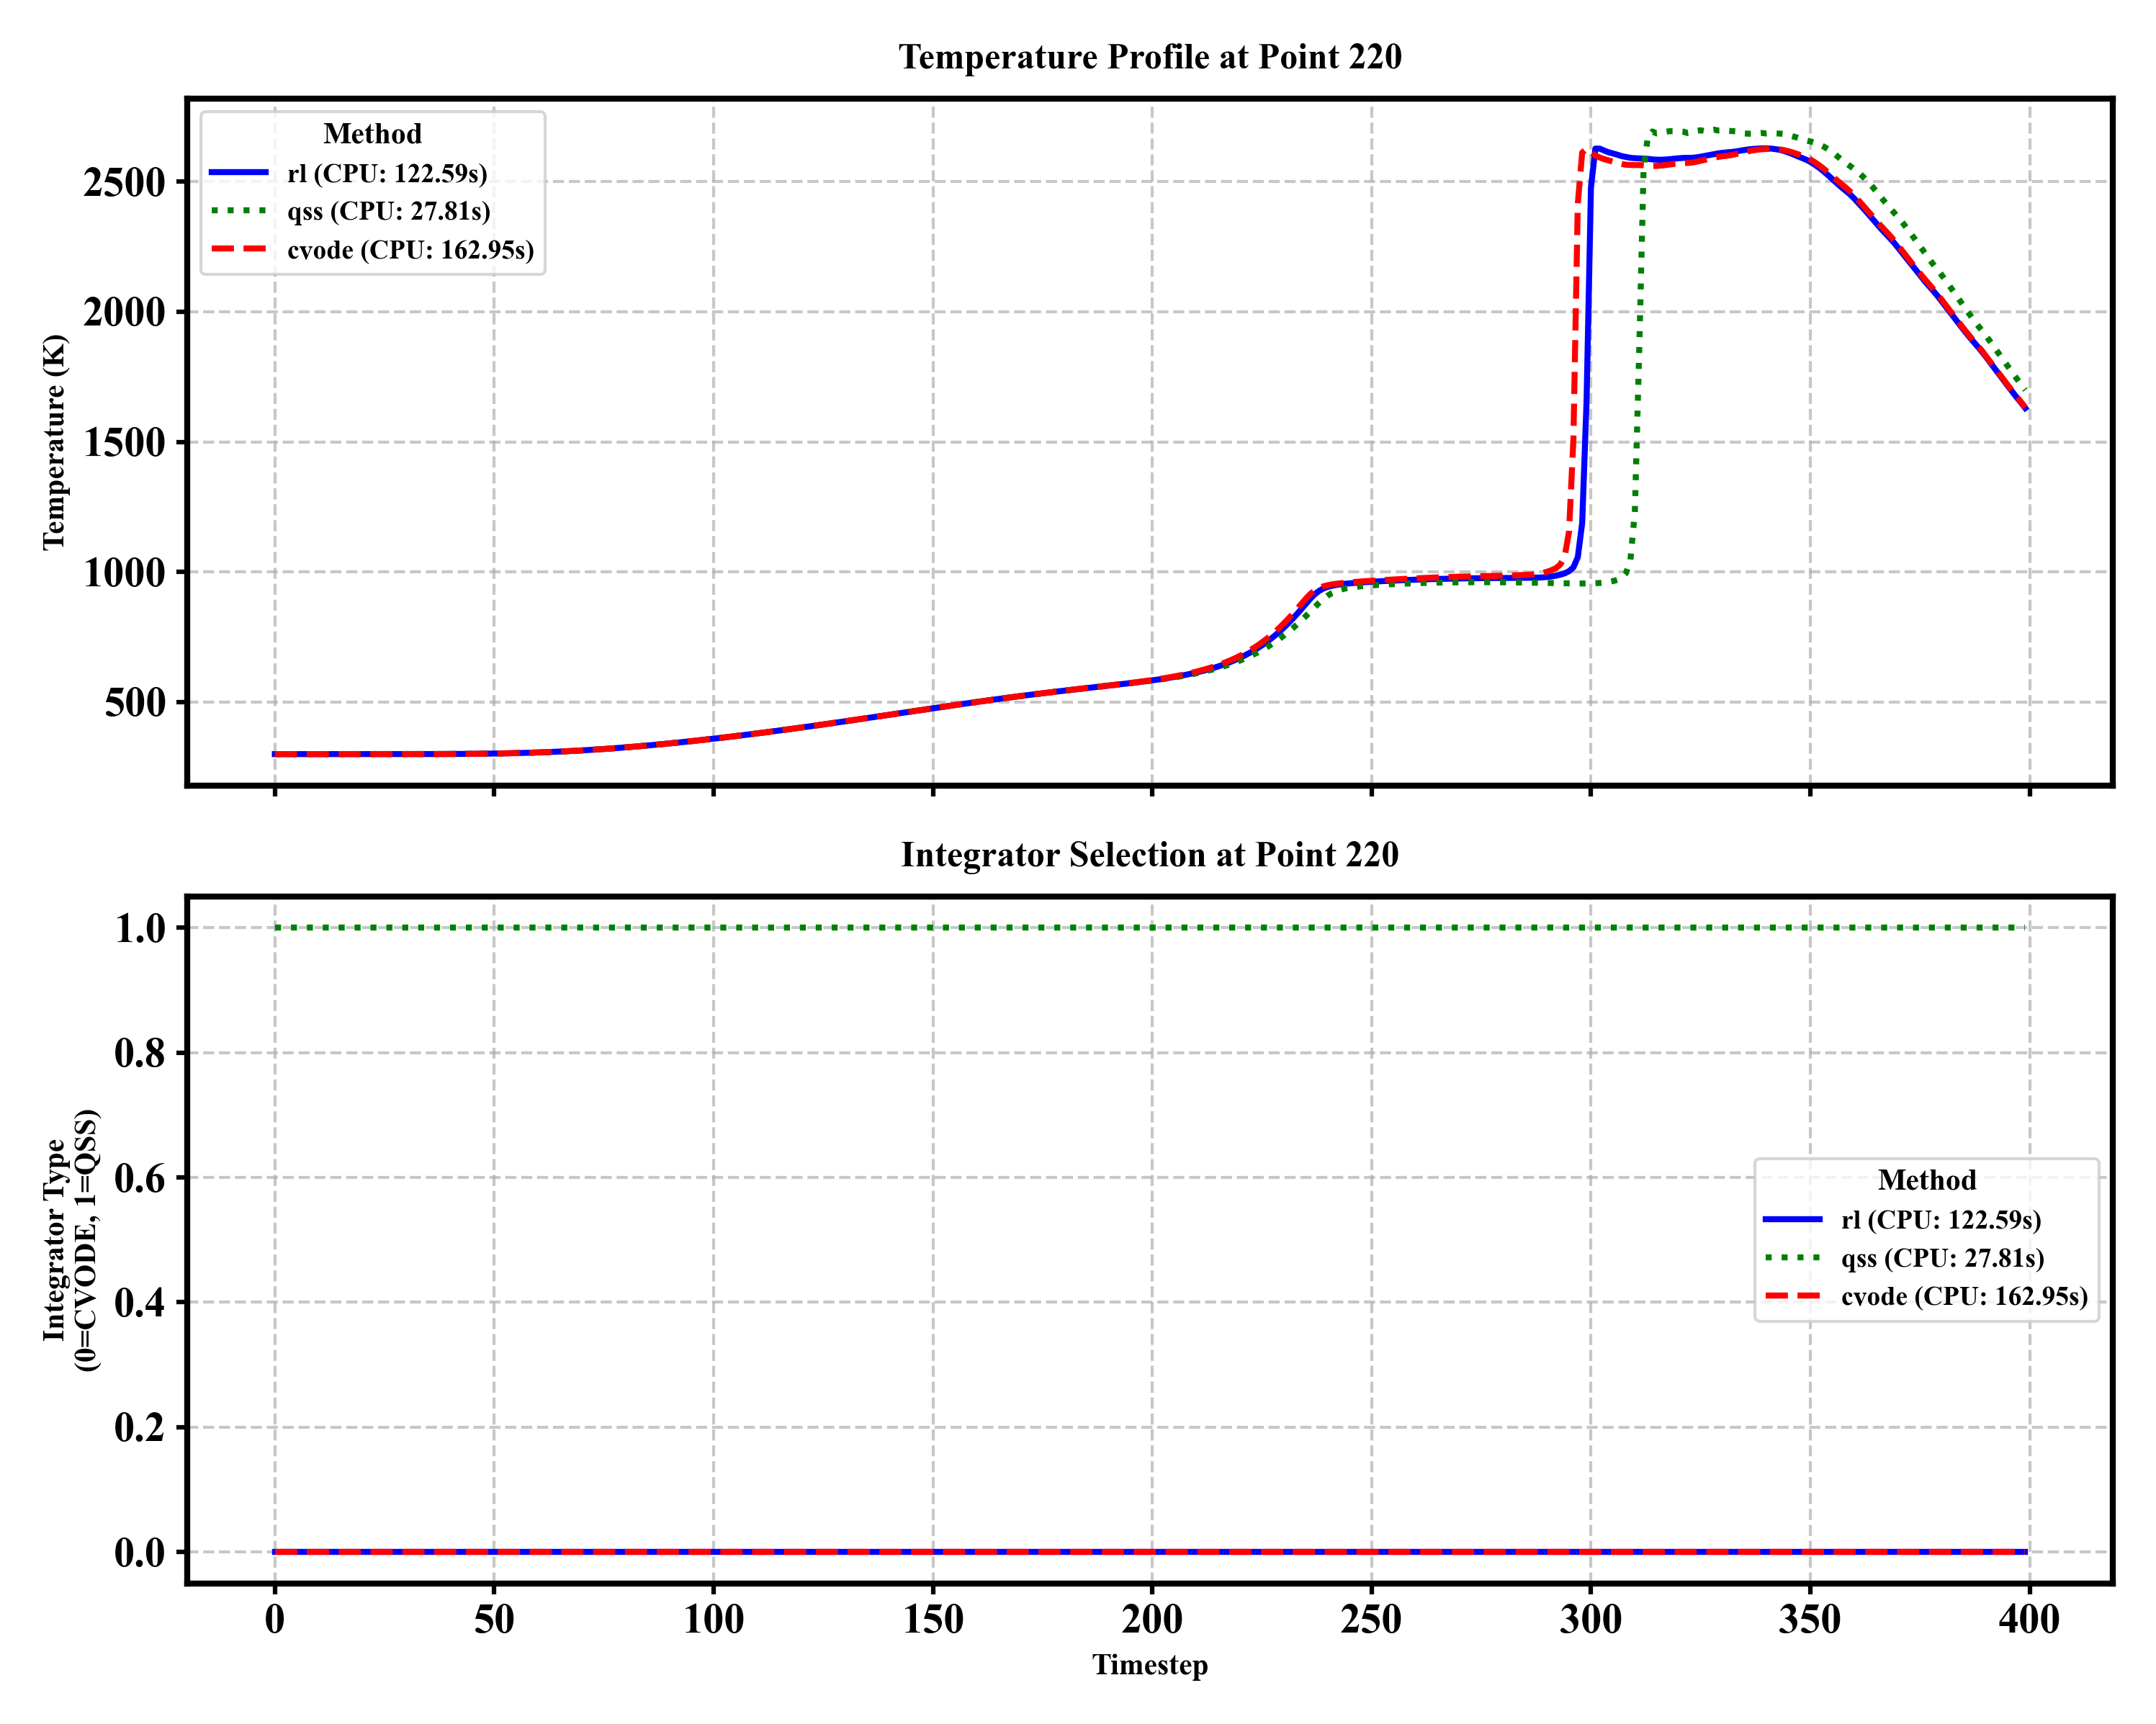

In [121]:
# Analysis of temperature and integrator profiles at point 50
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, dpi=300)

# Define colors and line styles for each method
styles = {
    'rl': {'color': 'blue', 'linestyle': '-', 'label': 'RL'},
    'cvode': {'color': 'red', 'linestyle': '--', 'label': 'CVODE'}, 
    'qss': {'color': 'green', 'linestyle': ':', 'label': 'QSS'},
    'heuristic': {'color': 'purple', 'linestyle': '-.', 'label': 'Heuristic'}
}

probe = 220
methods = ['rl', 'qss',  'cvode']
for method in methods:
    T_history = np.array(results[method]['T_history'])
    Y_history = np.array(results[method]['Y_history'])
    integrator_history = np.array(results[method]['integrator_history'])
    T_profile = T_history[:, probe]
    Y_profile = Y_history[:, :, probe]
    integrator_type = integrator_history[:, probe]
    cpu_time = np.sum(results[method]['cpu_times'])
    
    styles[method]['label'] = f'{method} (CPU: {cpu_time:.2f}s)'
    
    # Convert integrator_type to int (cvode = 0, qss = 1)
    integrator_type = np.where(integrator_type == 'cvode', 0, 1)
    
    # Plot temperature profile
    axs[0].plot(np.arange(len(T_profile)), T_profile, 
                **styles[method], linewidth=2)
    
    # Plot integrator type
    axs[1].plot(np.arange(len(integrator_type)), integrator_type,
                **styles[method], linewidth=2)

# Customize top plot
axs[0].set_title(f'Temperature Profile at Point {probe}', fontsize=12, pad=10)
axs[0].set_ylabel('Temperature (K)', fontsize=10)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].legend(title='Method', fontsize=9, title_fontsize=10)

# Customize bottom plot  
axs[1].set_title(f'Integrator Selection at Point {probe}', fontsize=12, pad=10)
axs[1].set_xlabel('Timestep', fontsize=10)
axs[1].set_ylabel('Integrator Type\n(0=CVODE, 1=QSS)', fontsize=10)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].legend(title='Method', fontsize=9, title_fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()




In [122]:
Y = np.array(results[method]['Y_history'])
print(Y.shape)

(400, 106, 500)


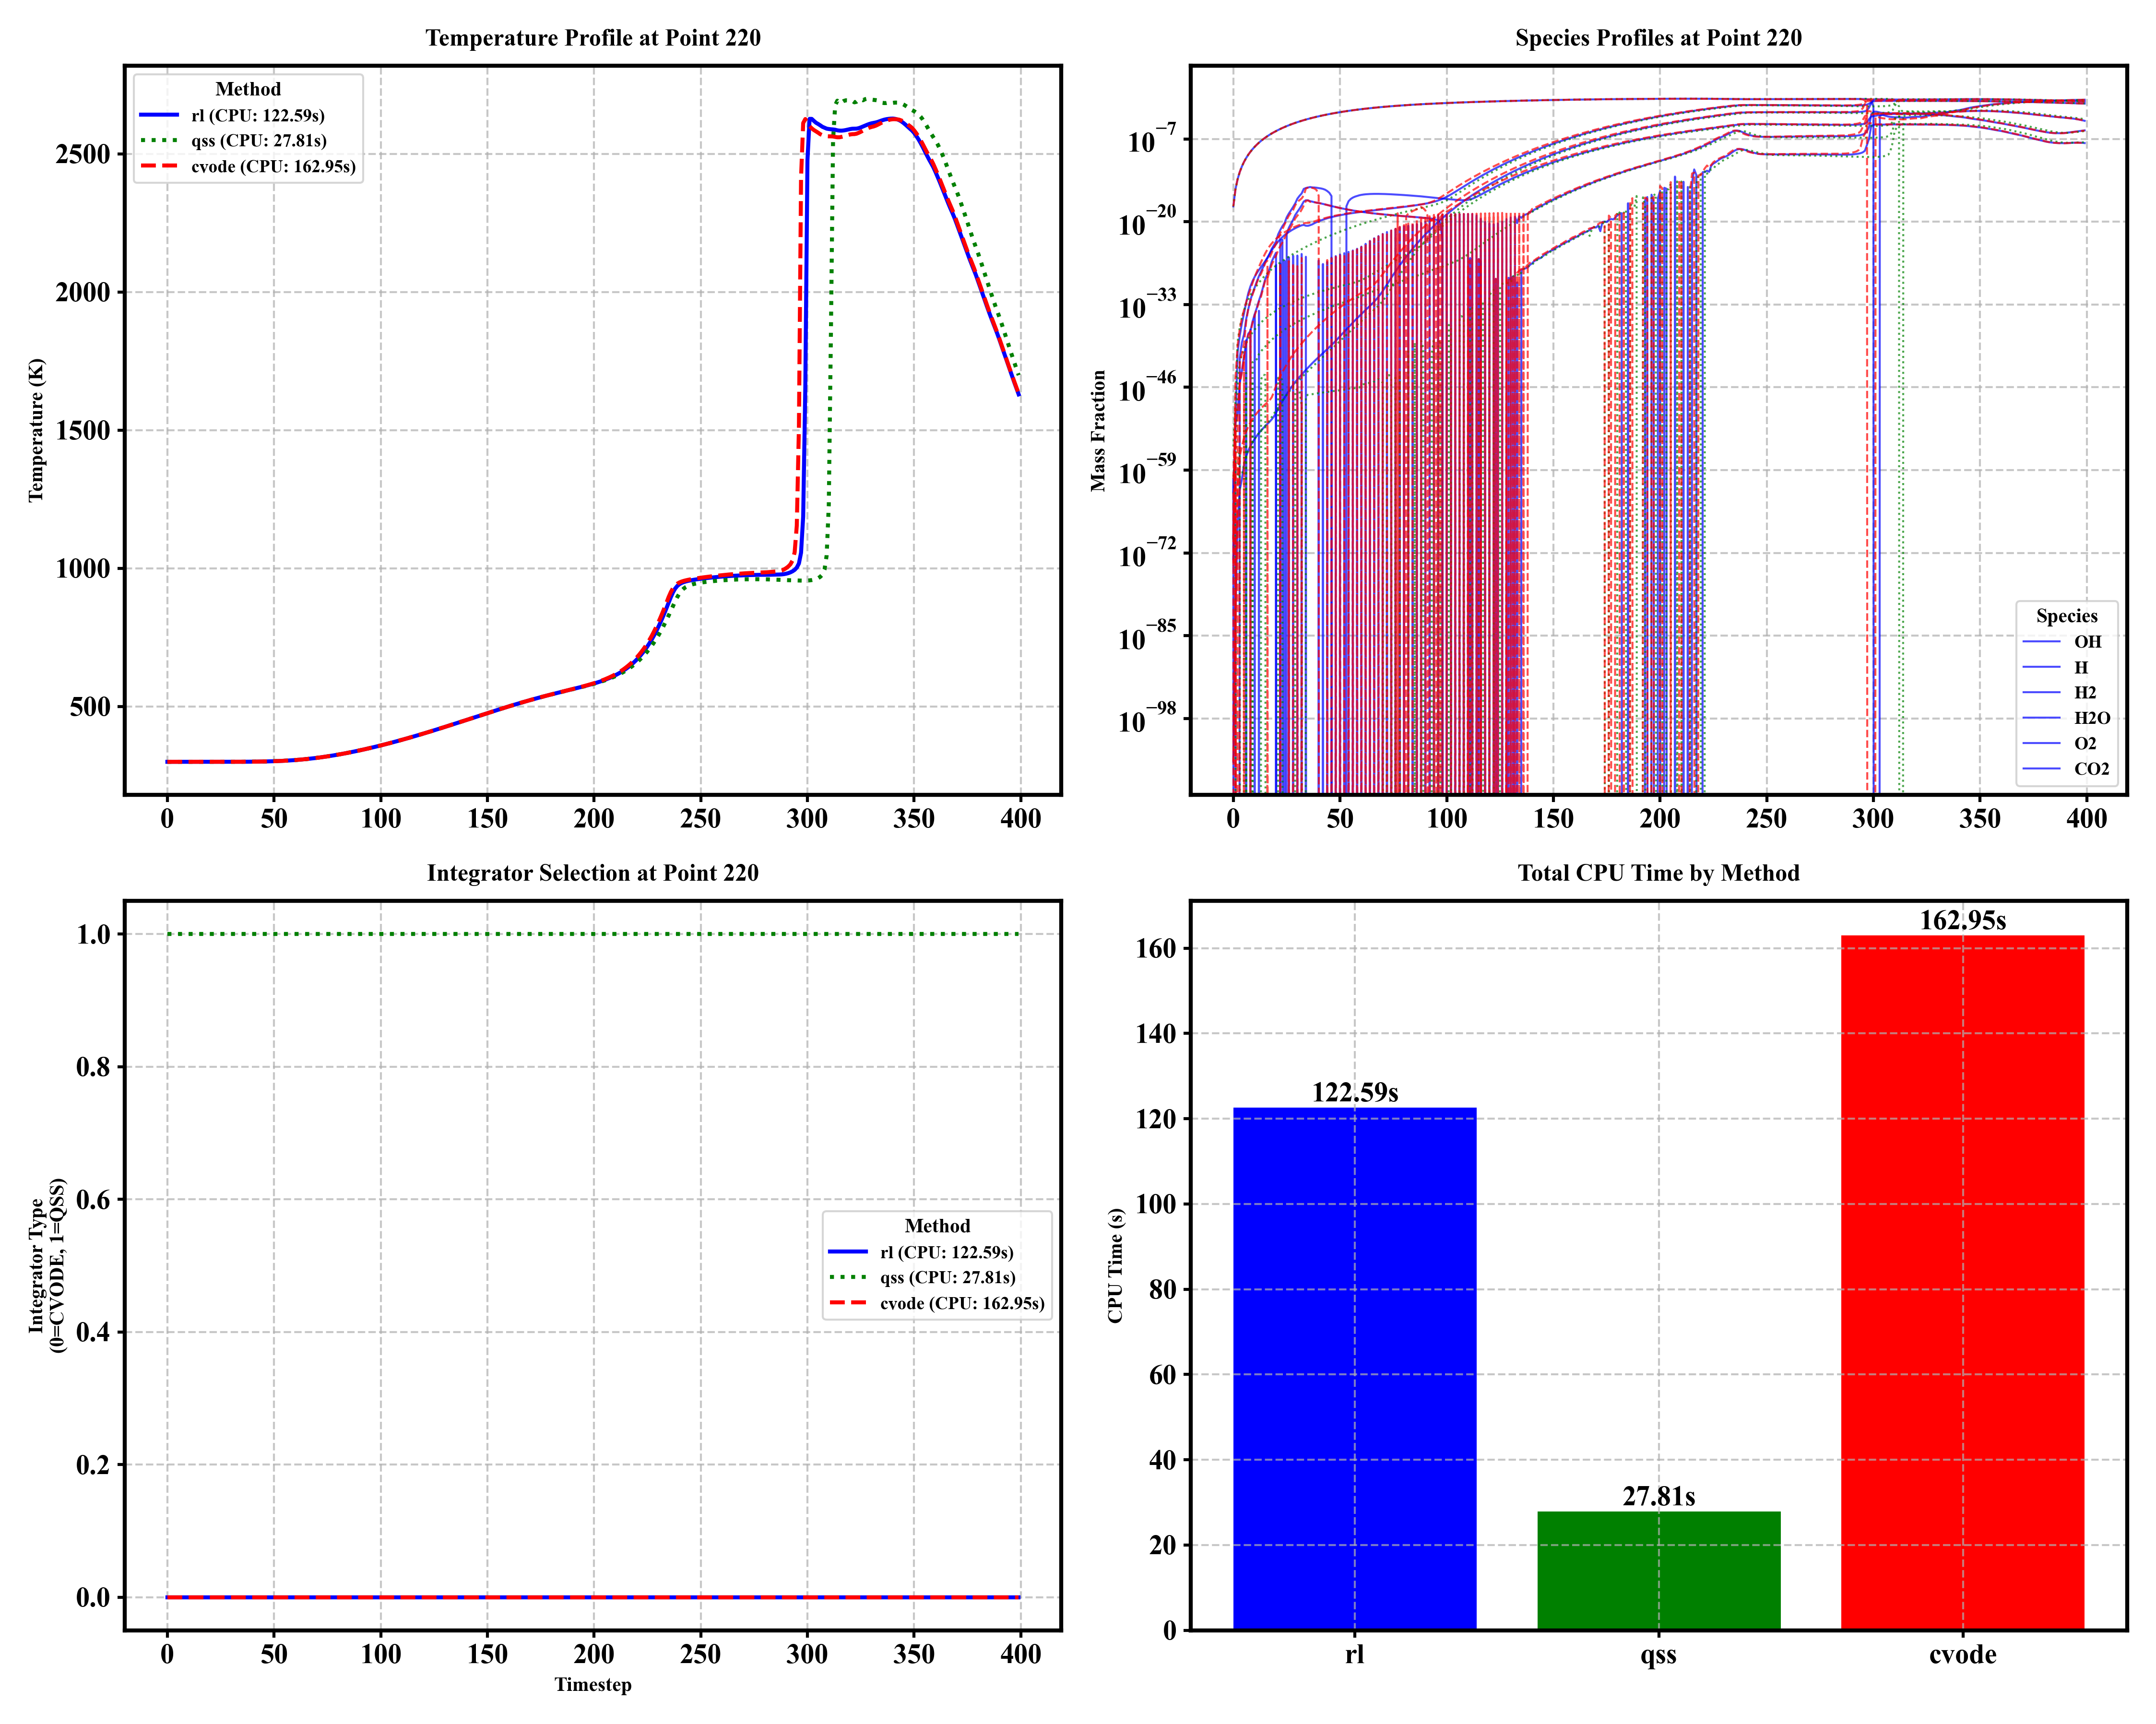

In [123]:
# Analysis of temperature, species, integrator profiles and CPU time at point 50
fig, axs = plt.subplots(2, 2, figsize=(15, 12), dpi=300)

# Define colors and line styles for each method
styles = {
    'rl': {'color': 'blue', 'linestyle': '-', 'label': 'RL'},
    'cvode': {'color': 'red', 'linestyle': '--', 'label': 'CVODE'}, 
    'qss': {'color': 'green', 'linestyle': ':', 'label': 'QSS'},
    'heuristic': {'color': 'purple', 'linestyle': '-.', 'label': 'Heuristic'}
}

probe = 220
species_to_plot = ['OH', 'H', 'H2', 'H2O', 'O2', 'CO2']
gas = ct.Solution('large_mechanism/n-dodecane.yaml')
species_indices = [gas.species_index(spec) for spec in species_to_plot]

cpu_times_dict = {}  # Store CPU times for bar plot

for method in methods:
    T_history = np.array(results[method]['T_history'])
    Y_history = np.array(results[method]['Y_history'])
    integrator_history = np.array(results[method]['integrator_history'])
    T_profile = T_history[:, probe]
    Y_profile = Y_history[:, :, probe]
    integrator_type = integrator_history[:, probe]
    cpu_times = results[method]['cpu_times']
    
    cpu_time = np.sum(cpu_times)
    cpu_times_dict[method] = cpu_time
    
    styles[method]['label'] = f'{method} (CPU: {cpu_time:.2f}s)'
    
    # Convert integrator_type to int (cvode = 0, qss = 1)
    integrator_type = np.where(integrator_type == 'cvode', 0, 1)
    
    # Plot temperature profile (top left)
    axs[0,0].plot(np.arange(len(T_profile)), T_profile, 
                **styles[method], linewidth=2)
    
    # Plot species profiles (top right)
    for i, species_idx in enumerate(species_indices):
        axs[0,1].plot(np.arange(len(Y_profile)), Y_profile[:, species_idx],
                    **styles[method], alpha=0.7, linewidth=1)
    
    # Plot integrator type (bottom left)
    axs[1,0].plot(np.arange(len(integrator_type)), integrator_type,
                **styles[method], linewidth=2)

# Plot CPU time comparison (bottom right)
methods_list = list(cpu_times_dict.keys())
times_list = [cpu_times_dict[m] for m in methods_list]
colors = [styles[m]['color'] for m in methods_list]
axs[1,1].bar(methods_list, times_list, color=colors)

# Customize temperature plot
axs[0,0].set_title(f'Temperature Profile at Point {probe}', fontsize=12, pad=10)
axs[0,0].set_ylabel('Temperature (K)', fontsize=10)
axs[0,0].grid(True, linestyle='--', alpha=0.7)
axs[0,0].legend(title='Method', fontsize=9, title_fontsize=10)

# Customize species plot
axs[0,1].set_title(f'Species Profiles at Point {probe}', fontsize=12, pad=10)
axs[0,1].set_ylabel('Mass Fraction', fontsize=10)
axs[0,1].grid(True, linestyle='--', alpha=0.7)
axs[0,1].legend(species_to_plot, title='Species', fontsize=9, title_fontsize=10)
axs[0,1].set_yscale('log')

# Customize integrator plot
axs[1,0].set_title(f'Integrator Selection at Point {probe}', fontsize=12, pad=10)
axs[1,0].set_xlabel('Timestep', fontsize=10)
axs[1,0].set_ylabel('Integrator Type\n(0=CVODE, 1=QSS)', fontsize=10)
axs[1,0].grid(True, linestyle='--', alpha=0.7)
axs[1,0].legend(title='Method', fontsize=9, title_fontsize=10)

# Customize CPU time plot
axs[1,1].set_title('Total CPU Time by Method', fontsize=12, pad=10)
axs[1,1].set_ylabel('CPU Time (s)', fontsize=10)
axs[1,1].grid(True, linestyle='--', alpha=0.7)
for i, v in enumerate(times_list):
    axs[1,1].text(i, v, f'{v:.2f}s', ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()


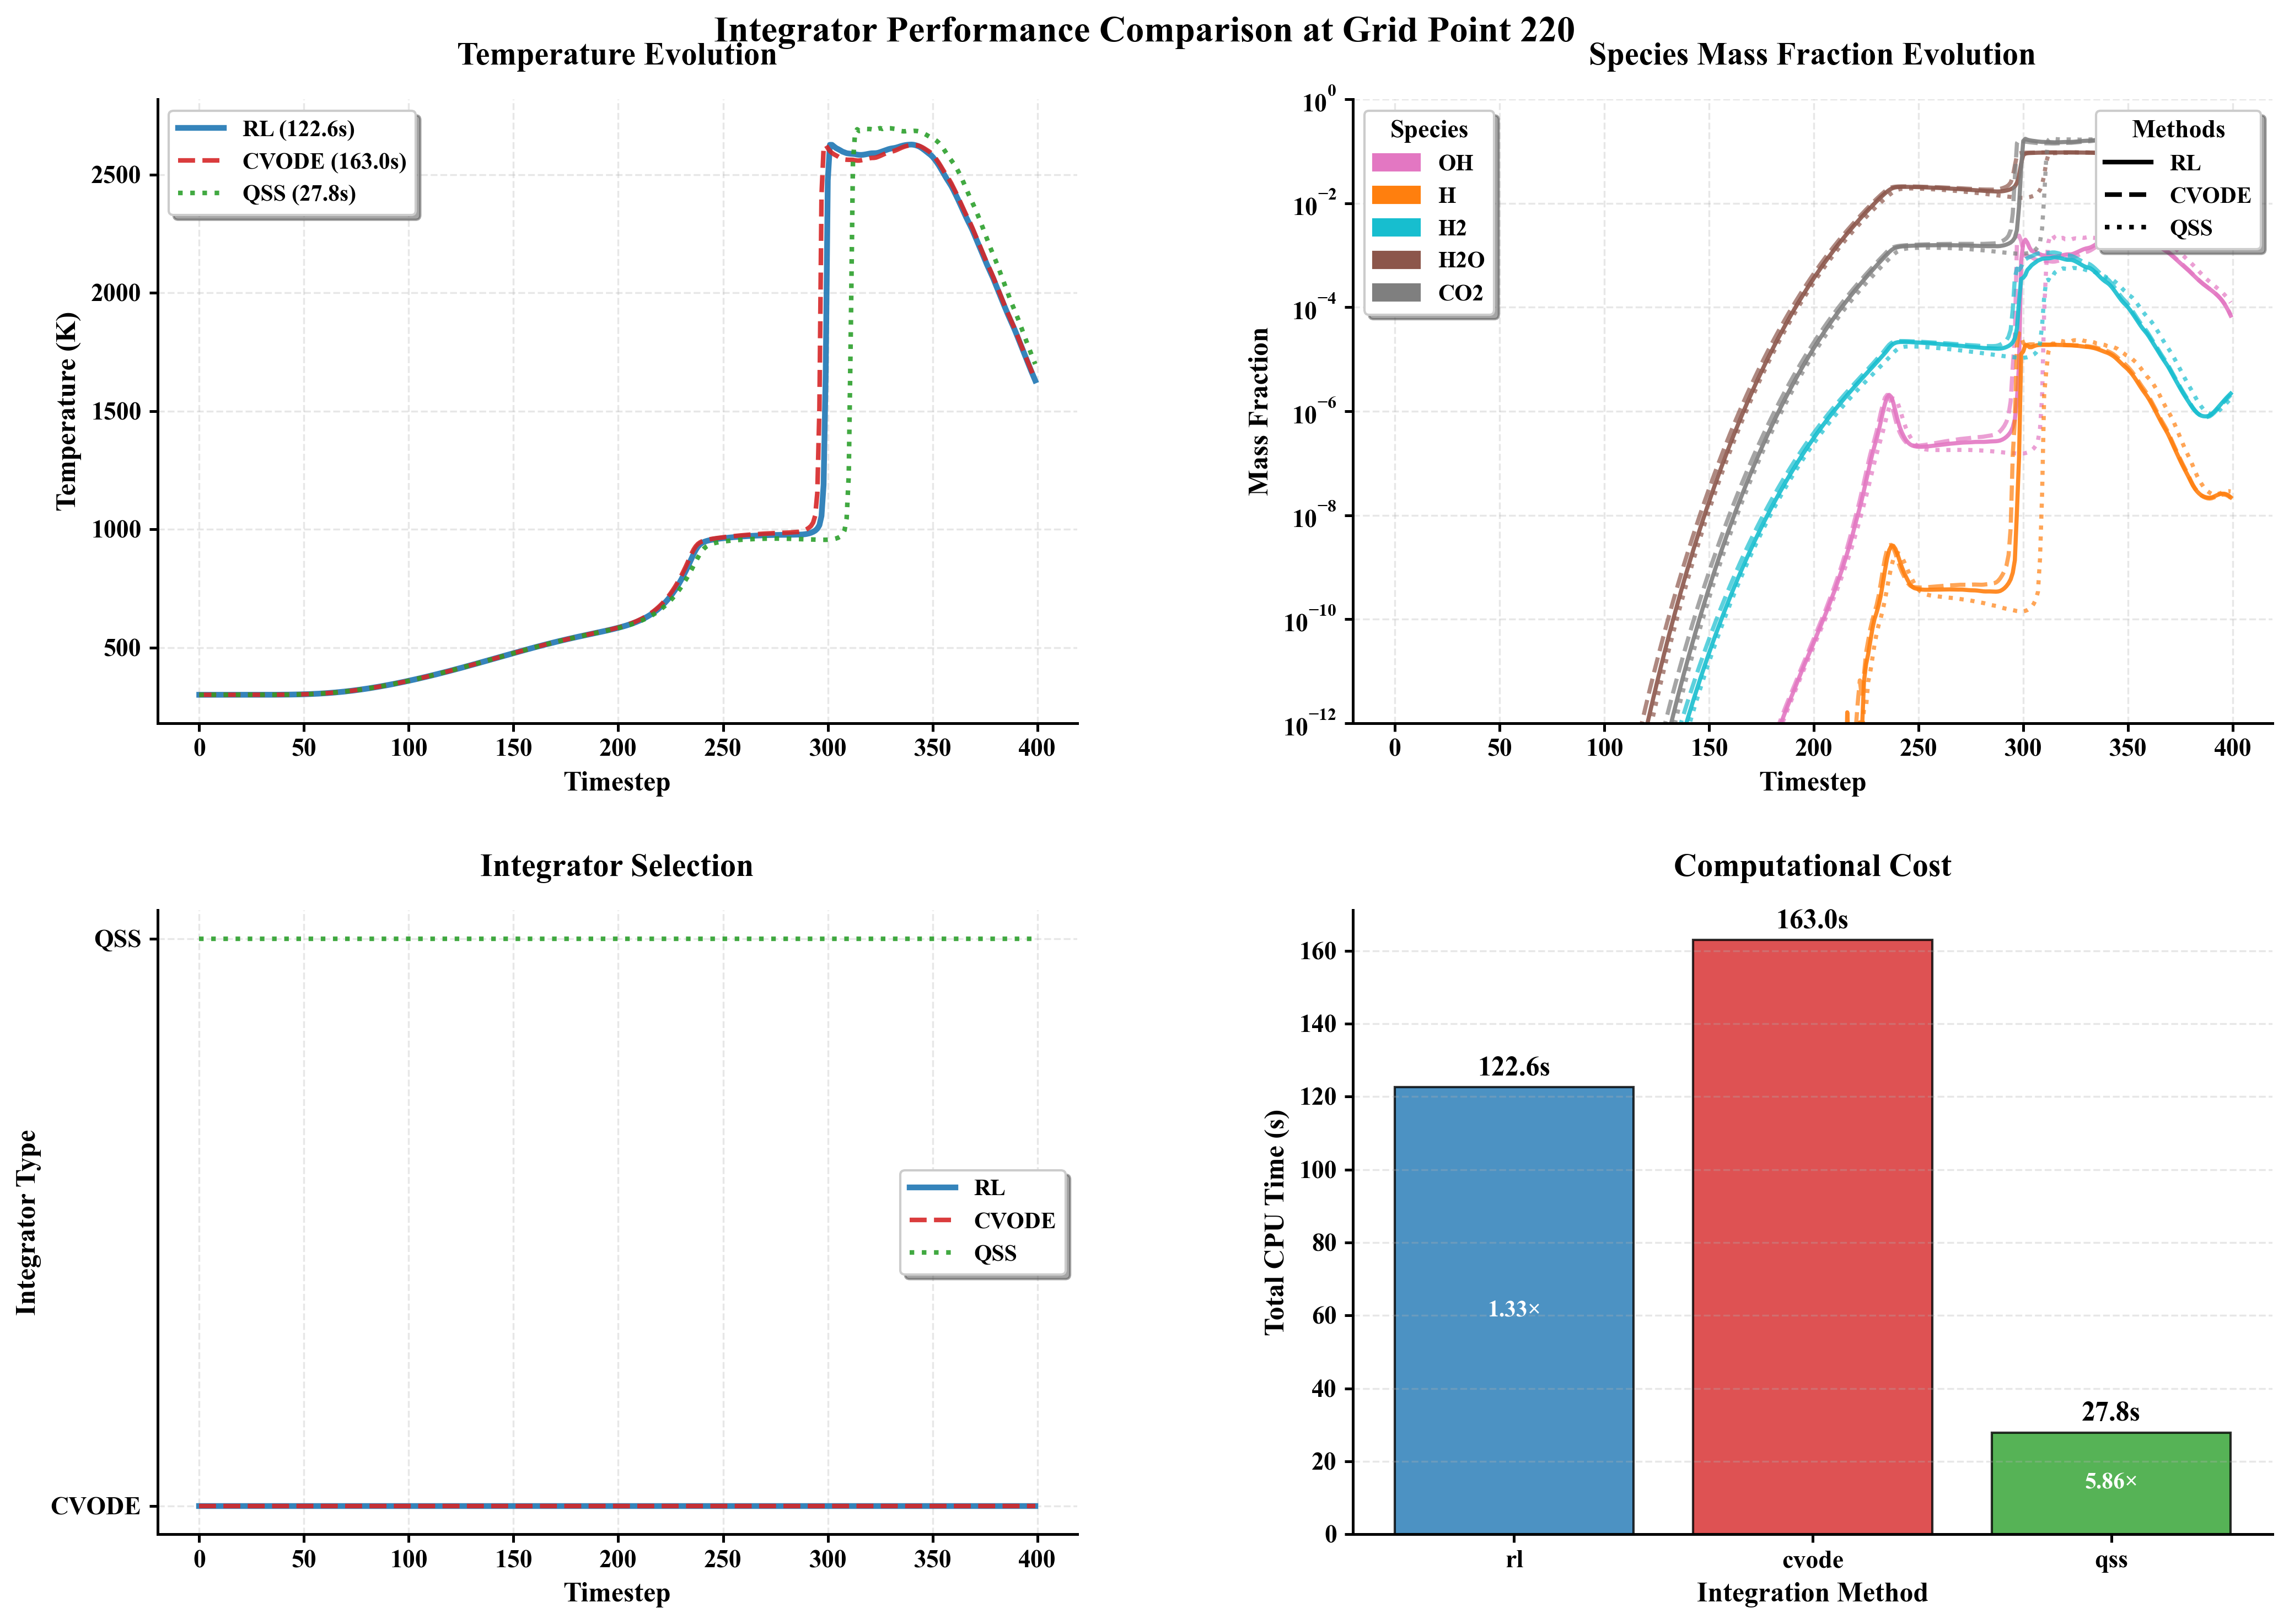


PERFORMANCE SUMMARY
Method       CPU Time (s)    Speedup    Relative Efficiency
-----------------------------------------------------------------
RL           122.589         1.33      × 132.9             %
CVODE        162.953         1.00      × 100.0             %
QSS          27.812          5.86      × 585.9             %


In [124]:
import matplotlib.pyplot as plt
import numpy as np
import cantera as ct
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches

# Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.linewidth': 1.2,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,
    'lines.linewidth': 2.0,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})
probe = 220
# Analysis of temperature, species, integrator profiles and CPU time at point 50
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Integrator Performance Comparison at Grid Point {probe}', fontsize=16, fontweight='bold')

# Define colors and line styles for each method
method_styles = {
    'rl': {'color': '#1f77b4', 'linestyle': '-', 'marker': None, 'linewidth': 2.5},
    'cvode': {'color': '#d62728', 'linestyle': '--', 'marker': None, 'linewidth': 2.0}, 
    'qss': {'color': '#2ca02c', 'linestyle': ':', 'marker': None, 'linewidth': 2.0},
    'heuristic': {'color': '#9467bd', 'linestyle': '-.', 'marker': None, 'linewidth': 2.0}
}

# Species colors (distinct colors for clear identification)
species_colors = {
    'OH': '#e377c2',    # Pink
    'H': '#ff7f0e',     # Orange
    'H2': '#17becf',    # Cyan
    'H2O': '#8c564b',   # Brown
    'O2': '#bcbd22',    # Olive
    'CO2': '#7f7f7f'    # Gray
}


species_to_plot = ['OH', 'H', 'H2', 'H2O', 'CO2']
gas = ct.Solution('large_mechanism/n-dodecane.yaml')  # Update path as needed
species_indices = [gas.species_index(spec) for spec in species_to_plot]

cpu_times_dict = {}  # Store CPU times for bar plot
methods = ['rl', 'cvode', 'qss', 'heuristic']  # Define methods order

# Assume results is your data dictionary
# results = {...}  # Your existing results dictionary

for method in methods:
    if method not in results or results[method] is None:
        continue
        
    T_history = np.array(results[method]['T_history'])
    Y_history = np.array(results[method]['Y_history'])
    integrator_history = np.array(results[method]['integrator_history'])
    T_profile = T_history[:, probe]
    Y_profile = Y_history[:, :, probe]
    integrator_type = integrator_history[:, probe]
    cpu_times = results[method]['cpu_times']
    
    cpu_time = np.sum(cpu_times)
    cpu_times_dict[method] = cpu_time
    
    # Convert integrator_type to int (cvode = 0, qss = 1)
    integrator_type_numeric = np.where(integrator_type == 'cvode', 0, 1)
    
    # Plot 1: Temperature profile (top left)
    axs[0,0].plot(np.arange(len(T_profile)), T_profile, 
                 color=method_styles[method]['color'],
                 linestyle=method_styles[method]['linestyle'],
                 linewidth=method_styles[method]['linewidth'],
                 label=f'{method.upper()} ({cpu_time:.1f}s)',
                 alpha=0.9)
    
    # Plot 3: Integrator type (bottom left)
    axs[1,0].plot(np.arange(len(integrator_type_numeric)), integrator_type_numeric,
                 color=method_styles[method]['color'],
                 linestyle=method_styles[method]['linestyle'], 
                 linewidth=method_styles[method]['linewidth'],
                 label=f'{method.upper()}',
                 alpha=0.9)

# Plot 2: Species profiles (top right) - Fixed legend issue
for i, (species, species_idx) in enumerate(zip(species_to_plot, species_indices)):
    for j, method in enumerate(methods):
        if method not in results or results[method] is None:
            continue
            
        Y_history = np.array(results[method]['Y_history'])
        Y_profile = Y_history[:, :, probe]
        
        # Use species color, but vary alpha/style for different methods
        alpha = 0.9 if j == 0 else 0.7  # First method more opaque
        linestyle = ['-', '--', ':', '-.'][j % 4]
        
        line = axs[0,1].plot(np.arange(len(Y_profile)), Y_profile[:, species_idx],
                           color=species_colors[species],
                           linestyle=linestyle,
                           linewidth=1.8,
                           alpha=alpha,
                           label=f'{species} ({method.upper()})' if len(methods) > 1 else species)

# Create custom legend for species plot
species_patches = []
method_patches = []

for species in species_to_plot:
    species_patches.append(mpatches.Patch(color=species_colors[species], label=species))

for method in methods:
    if method in results and results[method] is not None:
        method_patches.append(plt.Line2D([0], [0], 
                                       color='black', 
                                       linestyle=method_styles[method]['linestyle'],
                                       linewidth=2,
                                       label=method.upper()))

# Plot 4: CPU time comparison (bottom right)
methods_present = [m for m in methods if m in cpu_times_dict]
times_list = [cpu_times_dict[m] for m in methods_present]
colors = [method_styles[m]['color'] for m in methods_present]
bars = axs[1,1].bar(methods_present, times_list, color=colors, alpha=0.8, 
                   edgecolor='black', linewidth=1)

# Customize temperature plot
axs[0,0].set_title('Temperature Evolution', fontweight='bold', pad=15)
axs[0,0].set_xlabel('Timestep')
axs[0,0].set_ylabel('Temperature (K)')
axs[0,0].grid(True, linestyle='--', alpha=0.3)
axs[0,0].legend(frameon=True, fancybox=True, shadow=True, loc='best')
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)

# Customize species plot
axs[0,1].set_title('Species Mass Fraction Evolution', fontweight='bold', pad=15)
axs[0,1].set_xlabel('Timestep')
axs[0,1].set_ylabel('Mass Fraction')
axs[0,1].grid(True, linestyle='--', alpha=0.3)
axs[0,1].set_yscale('log')
axs[0,1].set_ylim(1e-12, 1e0)

# Create two separate legends for species plot
legend1 = axs[0,1].legend(handles=species_patches, title='Species', 
                         loc='upper left', bbox_to_anchor=(0, 1), 
                         frameon=True, fancybox=True, shadow=True)
legend2 = axs[0,1].legend(handles=method_patches, title='Methods', 
                         loc='upper right', bbox_to_anchor=(1, 1),
                         frameon=True, fancybox=True, shadow=True)
axs[0,1].add_artist(legend1)  # Add first legend back
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)

# Customize integrator plot
axs[1,0].set_title('Integrator Selection', fontweight='bold', pad=15)
axs[1,0].set_xlabel('Timestep')
axs[1,0].set_ylabel('Integrator Type')
axs[1,0].set_yticks([0, 1])
axs[1,0].set_yticklabels(['CVODE', 'QSS'])
axs[1,0].grid(True, linestyle='--', alpha=0.3)
axs[1,0].legend(frameon=True, fancybox=True, shadow=True, loc='best')
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)

# Customize CPU time plot
axs[1,1].set_title('Computational Cost', fontweight='bold', pad=15)
axs[1,1].set_ylabel('Total CPU Time (s)')
axs[1,1].set_xlabel('Integration Method')
axs[1,1].grid(True, linestyle='--', alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, times_list)):
    height = bar.get_height()
    axs[1,1].text(bar.get_x() + bar.get_width()/2., height + max(times_list)*0.01,
                 f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')

# Calculate and display speedup
if 'cvode' in cpu_times_dict:
    baseline = cpu_times_dict['cvode']
    for i, (method, time) in enumerate(zip(methods_present, times_list)):
        if method != 'cvode':
            speedup = baseline / time
            axs[1,1].text(i, time/2, f'{speedup:.2f}×', ha='center', va='center',
                         fontweight='bold', color='white', fontsize=10)

axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)

# Set consistent x-label formatting
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.xaxis.set_tick_params(width=1.2)
    ax.yaxis.set_tick_params(width=1.2)

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.3)

# Save with high quality
plt.savefig('integrator_comparison_analysis.pdf', format='pdf', bbox_inches='tight')
plt.savefig('integrator_comparison_analysis.png', format='png', bbox_inches='tight')
plt.show()

# Print performance summary table
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
print(f"{'Method':<12} {'CPU Time (s)':<15} {'Speedup':<10} {'Relative Efficiency':<18}")
print("-"*65)

baseline_cpu = cpu_times_dict.get('cvode', max(cpu_times_dict.values()))
for method in methods_present:
    cpu_time = cpu_times_dict[method]
    speedup = baseline_cpu / cpu_time
    efficiency = (1.0 / cpu_time) * baseline_cpu * 100
    
    print(f"{method.upper():<12} {cpu_time:<15.3f} {speedup:<10.2f}× {efficiency:<18.1f}%")

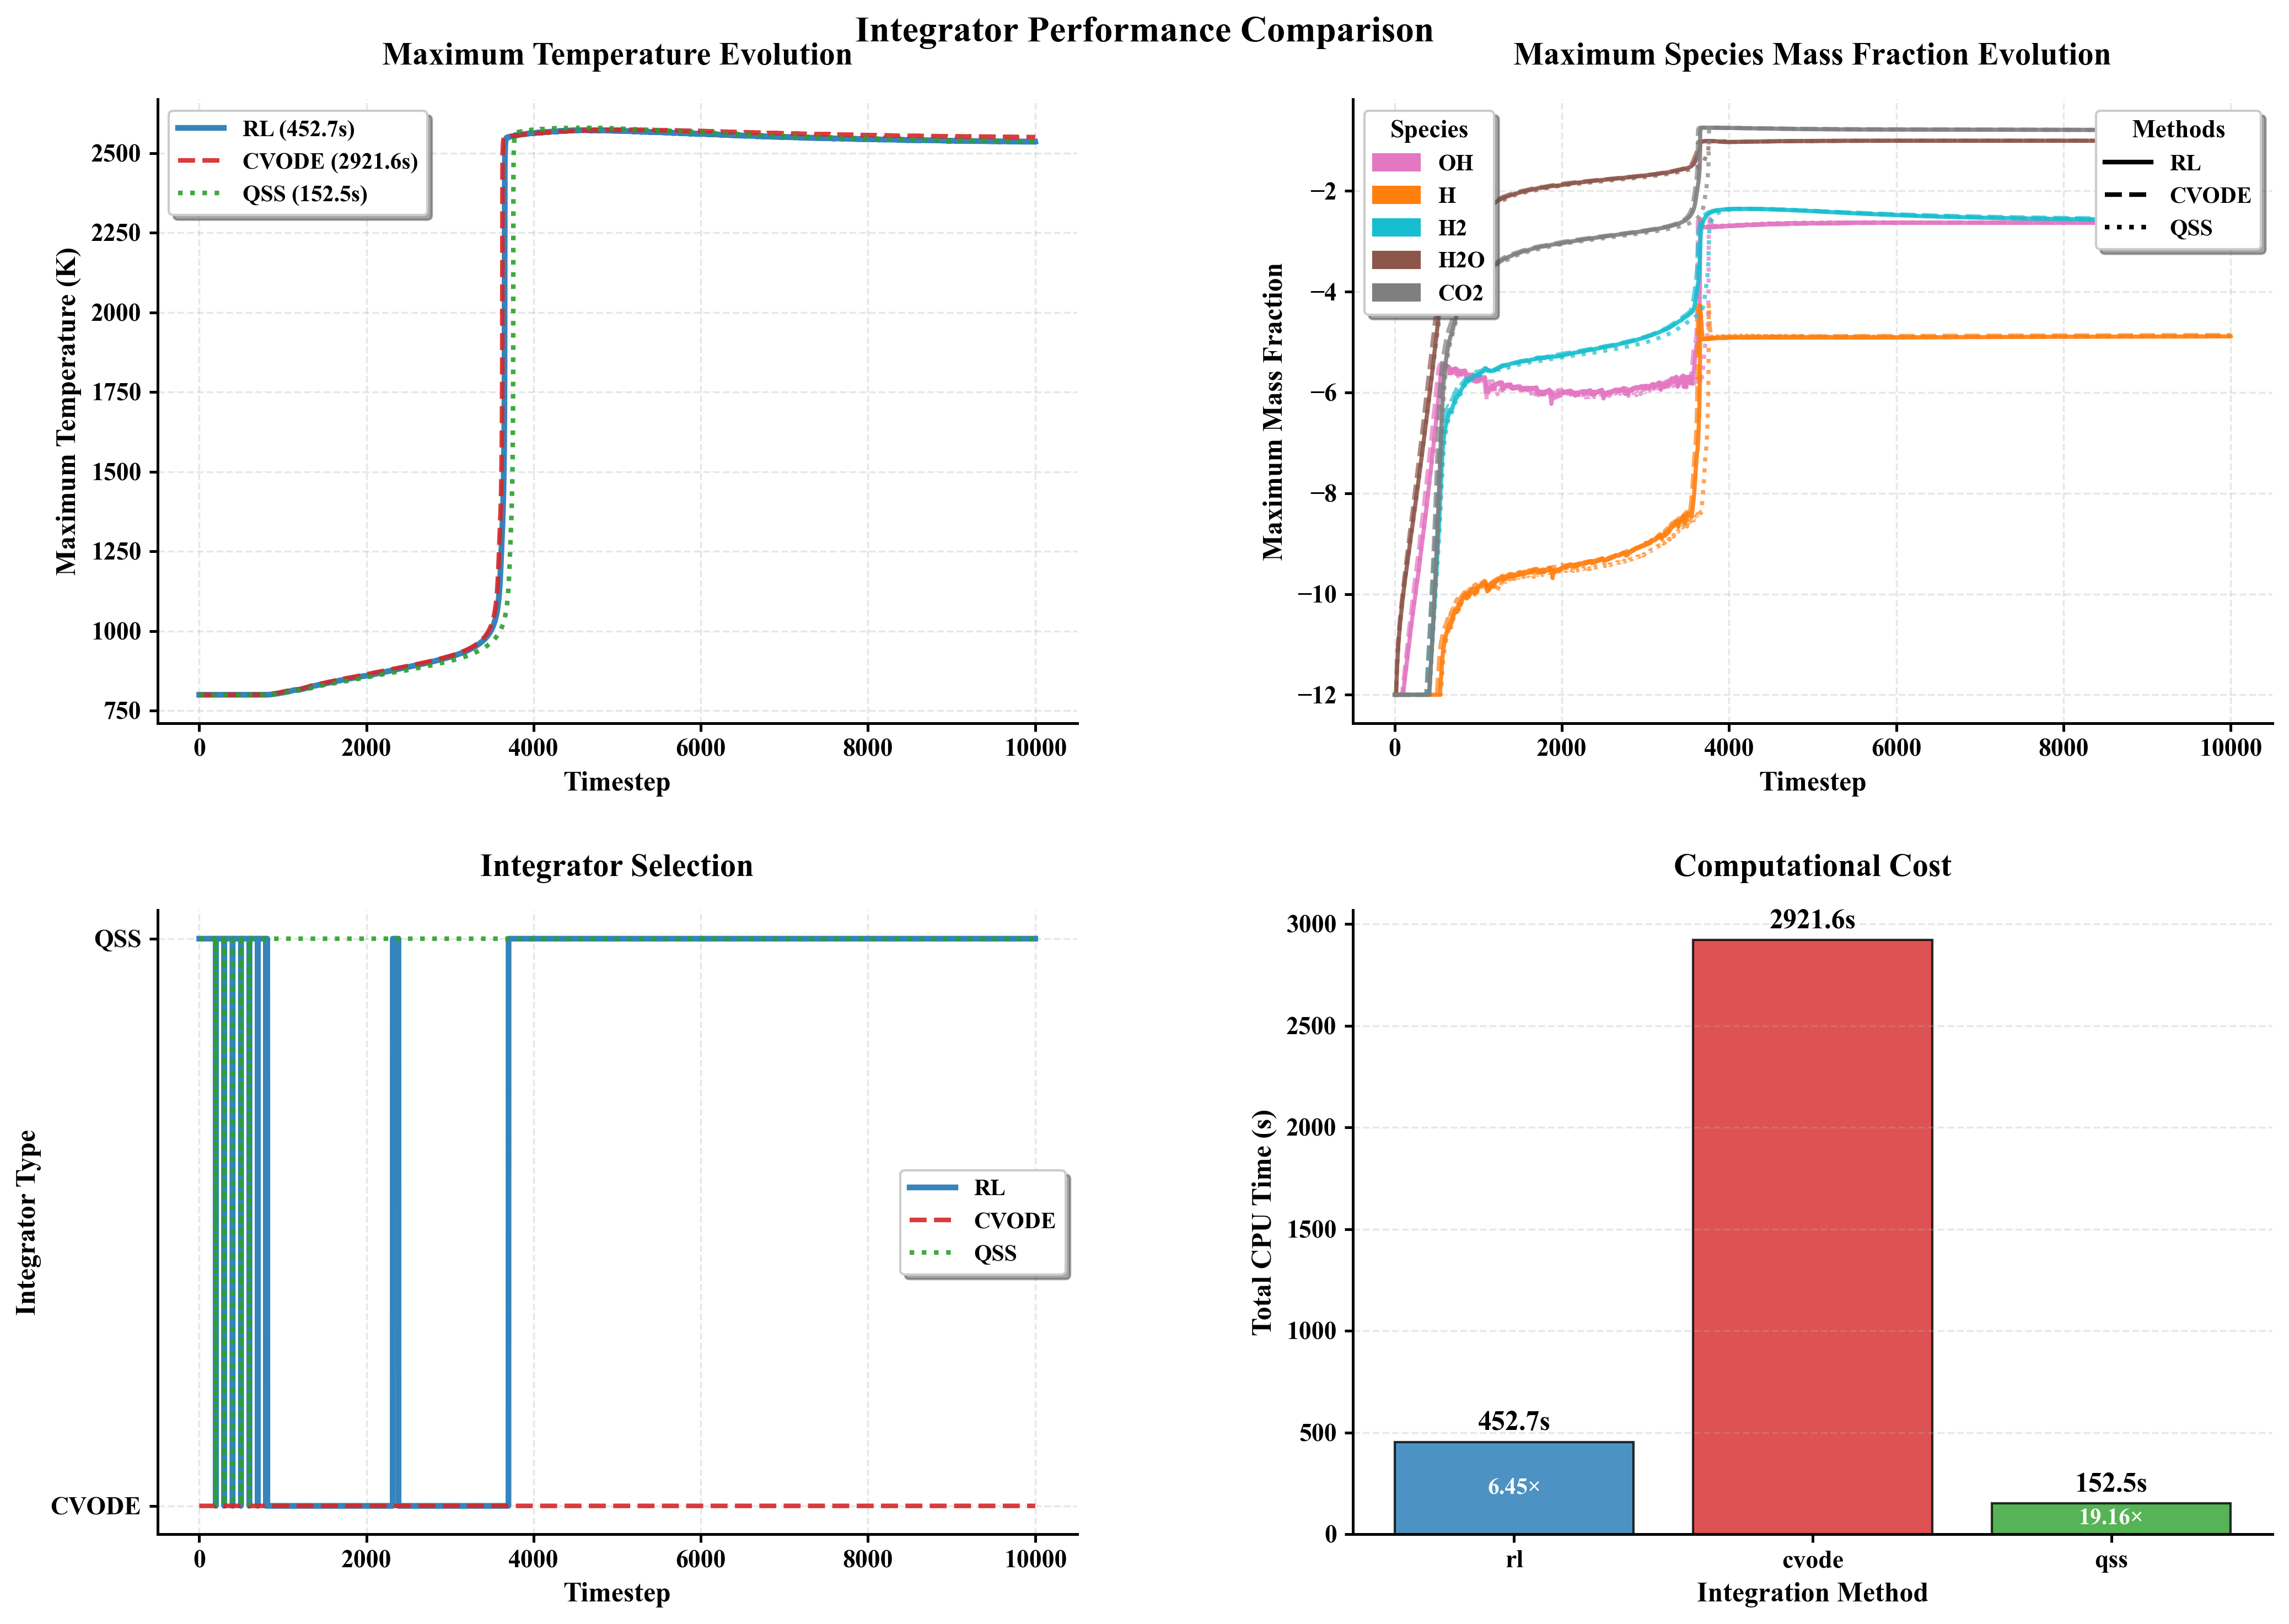


PERFORMANCE SUMMARY
Method       CPU Time (s)    Speedup    Relative Efficiency
-----------------------------------------------------------------
RL           452.665         6.45      × 645.4             %
CVODE        2921.562        1.00      × 100.0             %
QSS          152.512         19.16     × 1915.6            %


In [156]:
import matplotlib.pyplot as plt
import numpy as np
import cantera as ct
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches

# Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.linewidth': 1.2,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,
    'lines.linewidth': 2.0,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

# Analysis of temperature, species, integrator profiles and CPU time at point 50
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Integrator Performance Comparison', fontsize=16, fontweight='bold')

# Define colors and line styles for each method
method_styles = {
    'rl': {'color': '#1f77b4', 'linestyle': '-', 'marker': None, 'linewidth': 2.5},
    'cvode': {'color': '#d62728', 'linestyle': '--', 'marker': None, 'linewidth': 2.0}, 
    'qss': {'color': '#2ca02c', 'linestyle': ':', 'marker': None, 'linewidth': 2.0},
    'heuristic': {'color': '#9467bd', 'linestyle': '-.', 'marker': None, 'linewidth': 2.0}
}

# Species colors (distinct colors for clear identification)
species_colors = {
    'OH': '#e377c2',    # Pink
    'H': '#ff7f0e',     # Orange
    'H2': '#17becf',    # Cyan
    'H2O': '#8c564b',   # Brown
    'O2': '#bcbd22',    # Olive
    'CO2': '#7f7f7f'    # Gray
}

species_to_plot = ['OH', 'H', 'H2', 'H2O', 'CO2']
gas = ct.Solution('large_mechanism/n-dodecane.yaml')  # Update path as needed
species_indices = [gas.species_index(spec) for spec in species_to_plot]

cpu_times_dict = {}  # Store CPU times for bar plot
methods = ['rl', 'cvode', 'qss', 'heuristic']  # Define methods order

for method in methods:
    if method not in results or results[method] is None:
        continue
        
    T_history = results[method]['T_history']
    Y_history = results[method]['Y_history']
    integrator_history = results[method]['integrator_history']
    
    # Get maximum temperature across all grid points for each timestep
    T_max_profile = [np.max(T) for T in T_history]
    
    # Get the index of maximum temperature for each timestep
    max_temp_indices = [np.argmax(T) for T in T_history]
    
    # Get Y values at max temperature locations
    Y_max_profile = []
    for t, (Y, max_idx) in enumerate(zip(Y_history, max_temp_indices)):
        Y_max_profile.append(Y[:, max_idx])
    Y_max_profile = np.array(Y_max_profile)
    
    # Get integrator type at max temperature location, handling potential index mismatch
    integrator_type = []
    for i, idx in enumerate(max_temp_indices):
        if i < len(integrator_history) and idx < len(integrator_history[i]):
            integrator_type.append(integrator_history[i][idx])
        else:
            integrator_type.append('cvode')  # Default value if index out of range
    
    cpu_times = results[method]['cpu_times']
    cpu_time = np.sum(cpu_times)
    cpu_times_dict[method] = cpu_time
    
    # Convert integrator_type to int (cvode = 0, qss = 1)
    integrator_type_numeric = [0 if x == 'cvode' else 1 for x in integrator_type]
    
    # Plot 1: Maximum Temperature profile (top left)
    axs[0,0].plot(np.arange(len(T_max_profile)), T_max_profile, 
                 color=method_styles[method]['color'],
                 linestyle=method_styles[method]['linestyle'],
                 linewidth=method_styles[method]['linewidth'],
                 label=f'{method.upper()} ({cpu_time:.1f}s)',
                 alpha=0.9)
    
    # Plot 3: Integrator type (bottom left)
    axs[1,0].plot(np.arange(len(integrator_type_numeric)), integrator_type_numeric,
                 color=method_styles[method]['color'],
                 linestyle=method_styles[method]['linestyle'], 
                 linewidth=method_styles[method]['linewidth'],
                 label=f'{method.upper()}',
                 alpha=0.9)

# Plot 2: Maximum Species profiles (top right)
for i, (species, species_idx) in enumerate(zip(species_to_plot, species_indices)):
    for j, method in enumerate(methods):
        if method not in results or results[method] is None:
            continue
            
        Y_history = results[method]['Y_history']
        Y_max_profile = []
        for Y in Y_history:
            Y_max = np.max(Y[species_idx, :])
            Y_max_profile.append(Y_max)
        
        # Use species color, but vary alpha/style for different methods
        alpha = 0.9 if j == 0 else 0.7  # First method more opaque
        linestyle = ['-', '--', ':', '-.'][j % 4]
        
        line = axs[0,1].plot(np.arange(len(Y_max_profile)), np.log10(np.maximum(Y_max_profile, 1e-12)),
                           color=species_colors[species],
                           linestyle=linestyle,
                           linewidth=1.8,
                           alpha=alpha,
                           label=f'{species} ({method.upper()})' if len(methods) > 1 else species)

# Create custom legend for species plot
species_patches = []
method_patches = []

for species in species_to_plot:
    species_patches.append(mpatches.Patch(color=species_colors[species], label=species))

for method in methods:
    if method in results and results[method] is not None:
        method_patches.append(plt.Line2D([0], [0], 
                                       color='black', 
                                       linestyle=method_styles[method]['linestyle'],
                                       linewidth=2,
                                       label=method.upper()))

# Plot 4: CPU time comparison (bottom right)
methods_present = [m for m in methods if m in cpu_times_dict]
times_list = [cpu_times_dict[m] for m in methods_present]
colors = [method_styles[m]['color'] for m in methods_present]
bars = axs[1,1].bar(methods_present, times_list, color=colors, alpha=0.8, 
                   edgecolor='black', linewidth=1)

# Customize temperature plot
axs[0,0].set_title('Maximum Temperature Evolution', fontweight='bold', pad=15)
axs[0,0].set_xlabel('Timestep')
axs[0,0].set_ylabel('Maximum Temperature (K)')
axs[0,0].grid(True, linestyle='--', alpha=0.3)
axs[0,0].legend(frameon=True, fancybox=True, shadow=True, loc='best')
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)

# Customize species plot
axs[0,1].set_title('Maximum Species Mass Fraction Evolution', fontweight='bold', pad=15)
axs[0,1].set_xlabel('Timestep')
axs[0,1].set_ylabel('Maximum Mass Fraction')
axs[0,1].grid(True, linestyle='--', alpha=0.3)
# axs[0,1].set_yscale('log')
# axs[0,1].set_ylim(1e-12, 1e0)

# Create two separate legends for species plot
legend1 = axs[0,1].legend(handles=species_patches, title='Species', 
                         loc='upper left', bbox_to_anchor=(0, 1), 
                         frameon=True, fancybox=True, shadow=True)
legend2 = axs[0,1].legend(handles=method_patches, title='Methods', 
                         loc='upper right', bbox_to_anchor=(1, 1),
                         frameon=True, fancybox=True, shadow=True)
axs[0,1].add_artist(legend1)  # Add first legend back
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
# set y axis to log scale

# Customize integrator plot
axs[1,0].set_title('Integrator Selection', fontweight='bold', pad=15)
axs[1,0].set_xlabel('Timestep')
axs[1,0].set_ylabel('Integrator Type')
axs[1,0].set_yticks([0, 1])
axs[1,0].set_yticklabels(['CVODE', 'QSS'])
axs[1,0].grid(True, linestyle='--', alpha=0.3)
axs[1,0].legend(frameon=True, fancybox=True, shadow=True, loc='best')
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)

# Customize CPU time plot
axs[1,1].set_title('Computational Cost', fontweight='bold', pad=15)
axs[1,1].set_ylabel('Total CPU Time (s)')
axs[1,1].set_xlabel('Integration Method')
axs[1,1].grid(True, linestyle='--', alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, times_list)):
    height = bar.get_height()
    axs[1,1].text(bar.get_x() + bar.get_width()/2., height + max(times_list)*0.01,
                 f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')

# Calculate and display speedup
if 'cvode' in cpu_times_dict:
    baseline = cpu_times_dict['cvode']
    for i, (method, time) in enumerate(zip(methods_present, times_list)):
        if method != 'cvode':
            speedup = baseline / time
            axs[1,1].text(i, time/2, f'{speedup:.2f}×', ha='center', va='center',
                         fontweight='bold', color='white', fontsize=10)

axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)

# Set consistent x-label formatting
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.xaxis.set_tick_params(width=1.2)
    ax.yaxis.set_tick_params(width=1.2)

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.3)

# Save with high quality
plt.savefig('integrator_comparison_analysis.pdf', format='pdf', bbox_inches='tight')
plt.savefig('integrator_comparison_analysis.png', format='png', bbox_inches='tight')
plt.show()

# Print performance summary table
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
print(f"{'Method':<12} {'CPU Time (s)':<15} {'Speedup':<10} {'Relative Efficiency':<18}")
print("-"*65)

baseline_cpu = cpu_times_dict.get('cvode', max(cpu_times_dict.values()))
for method in methods_present:
    cpu_time = cpu_times_dict[method]
    speedup = baseline_cpu / cpu_time
    efficiency = (1.0 / cpu_time) * baseline_cpu * 100
    
    print(f"{method.upper():<12} {cpu_time:<15.3f} {speedup:<10.2f}× {efficiency:<18.1f}%")

IndexError: index 2000 is out of bounds for axis 0 with size 400

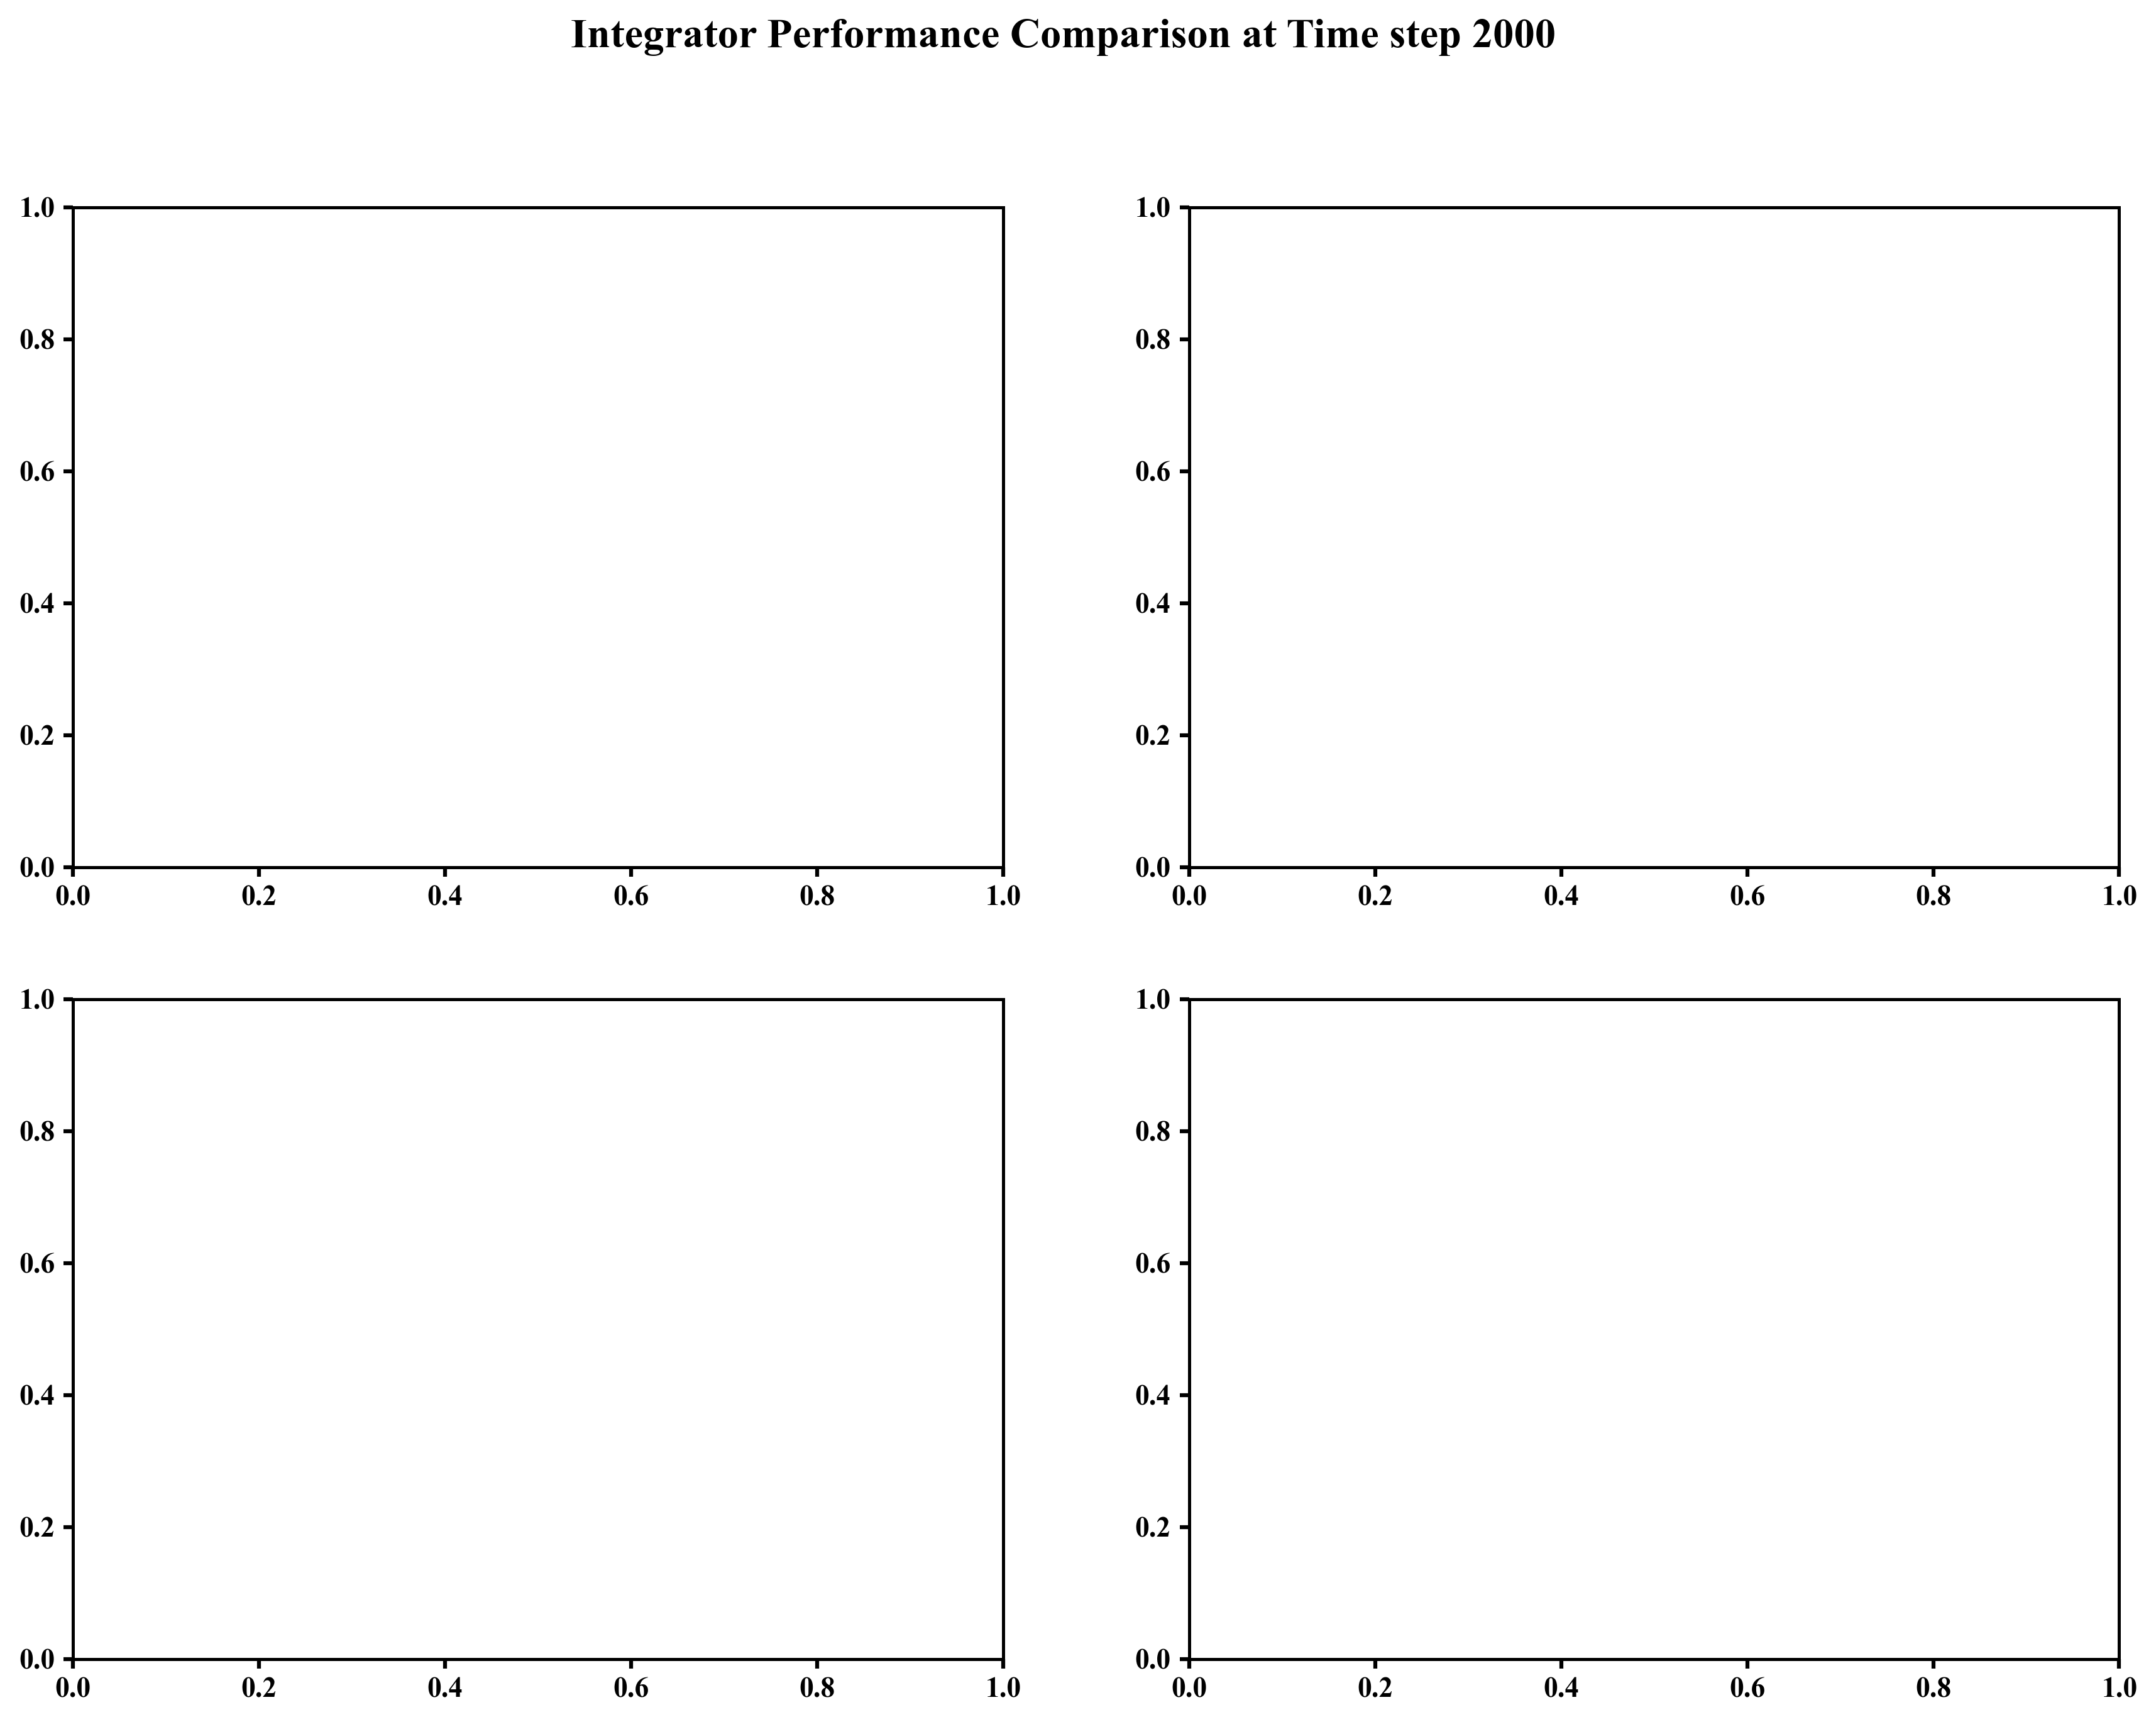

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import cantera as ct
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches

# Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.linewidth': 1.2,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,
    'lines.linewidth': 2.0,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})
time_probe = 2000
# Analysis of temperature, species, integrator profiles and CPU time at point 50
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Integrator Performance Comparison at Time step {time_probe}', fontsize=16, fontweight='bold')

# Define colors and line styles for each method
method_styles = {
    'rl': {'color': '#1f77b4', 'linestyle': '-', 'marker': None, 'linewidth': 2.5},
    'cvode': {'color': '#d62728', 'linestyle': '--', 'marker': None, 'linewidth': 2.0}, 
    'qss': {'color': '#2ca02c', 'linestyle': ':', 'marker': None, 'linewidth': 2.0},
    'heuristic': {'color': '#9467bd', 'linestyle': '-.', 'marker': None, 'linewidth': 2.0}
}

# Species colors (distinct colors for clear identification)
species_colors = {
    'OH': '#e377c2',    # Pink
    'H': '#ff7f0e',     # Orange
    'H2': '#17becf',    # Cyan
    'H2O': '#8c564b',   # Brown
    'O2': '#bcbd22',    # Olive
    'CO2': '#7f7f7f'    # Gray
}


species_to_plot = ['OH', 'H', 'H2', 'H2O', 'CO2']
gas = ct.Solution('large_mechanism/n-dodecane.yaml')  # Update path as needed
species_indices = [gas.species_index(spec) for spec in species_to_plot]

cpu_times_dict = {}  # Store CPU times for bar plot
methods = ['rl', 'cvode', 'qss', 'heuristic']  # Define methods order

# Assume results is your data dictionary
# results = {...}  # Your existing results dictionary

for method in methods:
    if method not in results or results[method] is None:
        continue
        
    T_history = np.array(results[method]['T_history'])
    Y_history = np.array(results[method]['Y_history'])
    integrator_history = np.array(results[method]['integrator_history'])
    T_profile = T_history[time_probe, :]
    Y_profile = Y_history[time_probe, :, :]
    integrator_type = integrator_history[time_probe, :]
    cpu_times = results[method]['cpu_times']
    
    cpu_time = np.sum(cpu_times)
    cpu_times_dict[method] = cpu_time
    
    # Convert integrator_type to int (cvode = 0, qss = 1)
    integrator_type_numeric = np.where(integrator_type == 'cvode', 0, 1)
    
    # Plot 1: Temperature profile (top left)
    axs[0,0].plot(np.arange(len(T_profile)), T_profile, 
                 color=method_styles[method]['color'],
                 linestyle=method_styles[method]['linestyle'],
                 linewidth=method_styles[method]['linewidth'],
                 label=f'{method.upper()} ({cpu_time:.1f}s)',
                 alpha=0.9)
    
    # Plot 3: Integrator type (bottom left)
    axs[1,0].plot(np.arange(len(integrator_type_numeric)), integrator_type_numeric,
                 color=method_styles[method]['color'],
                 linestyle=method_styles[method]['linestyle'], 
                 linewidth=method_styles[method]['linewidth'],
                 label=f'{method.upper()}',
                 alpha=0.9)

# Plot 2: Species profiles (top right) - Fixed legend issue
for i, (species, species_idx) in enumerate(zip(species_to_plot, species_indices)):
    for j, method in enumerate(methods):
        if method not in results or results[method] is None:
            continue
            
        Y_history = np.array(results[method]['Y_history'])
        Y_profile = Y_history[:, :, probe]
        
        # Use species color, but vary alpha/style for different methods
        alpha = 0.9 if j == 0 else 0.7  # First method more opaque
        linestyle = ['-', '--', ':', '-.'][j % 4]
        
        line = axs[0,1].plot(np.arange(len(Y_profile)), Y_profile[:, species_idx],
                           color=species_colors[species],
                           linestyle=linestyle,
                           linewidth=1.8,
                           alpha=alpha,
                           label=f'{species} ({method.upper()})' if len(methods) > 1 else species)

# Create custom legend for species plot
species_patches = []
method_patches = []

for species in species_to_plot:
    species_patches.append(mpatches.Patch(color=species_colors[species], label=species))

for method in methods:
    if method in results and results[method] is not None:
        method_patches.append(plt.Line2D([0], [0], 
                                       color='black', 
                                       linestyle=method_styles[method]['linestyle'],
                                       linewidth=2,
                                       label=method.upper()))

# Plot 4: CPU time comparison (bottom right)
methods_present = [m for m in methods if m in cpu_times_dict]
times_list = [cpu_times_dict[m] for m in methods_present]
colors = [method_styles[m]['color'] for m in methods_present]
bars = axs[1,1].bar(methods_present, times_list, color=colors, alpha=0.8, 
                   edgecolor='black', linewidth=1)

# Customize temperature plot
axs[0,0].set_title('Temperature Evolution', fontweight='bold', pad=15)
axs[0,0].set_xlabel('Timestep')
axs[0,0].set_ylabel('Temperature (K)')
axs[0,0].grid(True, linestyle='--', alpha=0.3)
axs[0,0].legend(frameon=True, fancybox=True, shadow=True, loc='best')
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)

# Customize species plot
axs[0,1].set_title('Species Mass Fraction Evolution', fontweight='bold', pad=15)
axs[0,1].set_xlabel('Timestep')
axs[0,1].set_ylabel('Mass Fraction')
axs[0,1].grid(True, linestyle='--', alpha=0.3)
axs[0,1].set_yscale('log')
axs[0,1].set_ylim(1e-12, 1e0)

# Create two separate legends for species plot
legend1 = axs[0,1].legend(handles=species_patches, title='Species', 
                         loc='upper left', bbox_to_anchor=(0, 1), 
                         frameon=True, fancybox=True, shadow=True)
legend2 = axs[0,1].legend(handles=method_patches, title='Methods', 
                         loc='upper right', bbox_to_anchor=(1, 1),
                         frameon=True, fancybox=True, shadow=True)
axs[0,1].add_artist(legend1)  # Add first legend back
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)

# Customize integrator plot
axs[1,0].set_title('Integrator Selection', fontweight='bold', pad=15)
axs[1,0].set_xlabel('Timestep')
axs[1,0].set_ylabel('Integrator Type')
axs[1,0].set_yticks([0, 1])
axs[1,0].set_yticklabels(['CVODE', 'QSS'])
axs[1,0].grid(True, linestyle='--', alpha=0.3)
axs[1,0].legend(frameon=True, fancybox=True, shadow=True, loc='best')
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)

# Customize CPU time plot
axs[1,1].set_title('Computational Cost', fontweight='bold', pad=15)
axs[1,1].set_ylabel('Total CPU Time (s)')
axs[1,1].set_xlabel('Integration Method')
axs[1,1].grid(True, linestyle='--', alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, times_list)):
    height = bar.get_height()
    axs[1,1].text(bar.get_x() + bar.get_width()/2., height + max(times_list)*0.01,
                 f'{value:.1f}s', ha='center', va='bottom', fontweight='bold')

# Calculate and display speedup
if 'cvode' in cpu_times_dict:
    baseline = cpu_times_dict['cvode']
    for i, (method, time) in enumerate(zip(methods_present, times_list)):
        if method != 'cvode':
            speedup = baseline / time
            axs[1,1].text(i, time/2, f'{speedup:.2f}×', ha='center', va='center',
                         fontweight='bold', color='white', fontsize=10)

axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)

# Set consistent x-label formatting
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.xaxis.set_tick_params(width=1.2)
    ax.yaxis.set_tick_params(width=1.2)

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.3)

# Save with high quality
plt.savefig('integrator_comparison_analysis.pdf', format='pdf', bbox_inches='tight')
plt.savefig('integrator_comparison_analysis.png', format='png', bbox_inches='tight')
plt.show()

# Print performance summary table
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
print(f"{'Method':<12} {'CPU Time (s)':<15} {'Speedup':<10} {'Relative Efficiency':<18}")
print("-"*65)

baseline_cpu = cpu_times_dict.get('cvode', max(cpu_times_dict.values()))
for method in methods_present:
    cpu_time = cpu_times_dict[method]
    speedup = baseline_cpu / cpu_time
    efficiency = (1.0 / cpu_time) * baseline_cpu * 100
    
    print(f"{method.upper():<12} {cpu_time:<15.3f} {speedup:<10.2f}× {efficiency:<18.1f}%")

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
from matplotlib.colors import ListedColormap
import pandas as pd
from matplotlib.patches import Patch
import seaborn as sns

In [82]:
# Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif', # Changed from serif to avoid H2O subscript issues
    'axes.linewidth': 1.2,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def extract_rl_data(results, mechanism_file, pressure=10*ct.one_atm, fuel='nc12h26', oxidizer='O2:1.0, N2:3.76'):
    """
    Extract all RL data points for analysis
    
    Args:
        results: Results dictionary containing RL data
        mechanism_file: Path to Cantera mechanism file
        pressure: Pressure in Pa (default 10 bar)
        fuel: Fuel composition string
        oxidizer: Oxidizer composition string
    
    Returns:
        Dictionary with extracted data arrays
    """
    print("Extracting RL data...")
    
    # Initialize Cantera gas object
    gas = ct.Solution(mechanism_file)
    
    # Get RL results
    
    rl_data = results[method]
    T_history = np.array(rl_data['T_history'])  # Shape: (timesteps, npoints)
    Y_history = np.array(rl_data['Y_history'])  # Shape: (timesteps, nspecies, npoints)
    integrator_history = rl_data['integrator_history']  # List of lists
    
    n_timesteps, n_points = T_history.shape
    n_species = Y_history.shape[1]
    
    print(f"Data dimensions: {n_timesteps} timesteps × {n_points} points × {n_species} species")
    
    # Flatten all data
    all_temperatures = []
    all_species = []
    all_actions = []
    all_phi = []
    all_points = []
    all_timesteps = []
    
    # Species of interest indices
    try:
        oh_idx = gas.species_index('OH')
    except:
        oh_idx = None
    
    try:
        h2o_idx = gas.species_index('H2O')
    except:
        h2o_idx = None
    
    all_oh = []
    all_h2o = []
    
    for t in range(n_timesteps):
        if t >= len(integrator_history):
            continue
            
        for p in range(n_points):
            try:
                # Extract state
                temperature = T_history[t, p]
                species_fractions = Y_history[t, :, p]
                
                # Skip if temperature is too low (unphysical or initialization)
                if temperature < 300:
                    continue
                
                # Get action (convert to integer)
                action_str = integrator_history[t][p] if p < len(integrator_history[t]) else 'cvode'
                action = 0 if action_str == 'cvode' else 1
                
                # Set gas state and calculate phi
                gas.TPY = temperature, pressure, species_fractions
                
                try:
                    phi = gas.equivalence_ratio(fuel, oxidizer)
                    # Filter out unphysical phi values
                    if phi <= 0 or phi > 100:
                        continue
                except:
                    continue
                
                # Store data
                all_temperatures.append(temperature)
                all_species.append(species_fractions.copy())
                all_actions.append(action)
                all_phi.append(phi)
                all_points.append(p)
                all_timesteps.append(t)
                
                # Store species of interest
                if oh_idx is not None:
                    all_oh.append(species_fractions[oh_idx])
                else:
                    all_oh.append(0.0)
                    
                if h2o_idx is not None:
                    all_h2o.append(species_fractions[h2o_idx])
                else:
                    all_h2o.append(0.0)
                    
            except Exception as e:
                continue
    
    print(f"Extracted {len(all_temperatures)} valid data points")
    
    return {
        'temperatures': np.array(all_temperatures),
        'species': np.array(all_species),
        'actions': np.array(all_actions),
        'phi': np.array(all_phi),
        'points': np.array(all_points),
        'timesteps': np.array(all_timesteps),
        'oh': np.array(all_oh),
        'h2o': np.array(all_h2o),
        'pressure': pressure
    }

def create_decision_boundary_analysis(data, save_path=None):
    """
    Create comprehensive scatter plots showing RL decision patterns
    
    Args:
        data: Dictionary from extract_rl_data
        save_path: Optional path to save figures
    """
    
    # Define colors for actions
    action_colors = {0: '#d62728', 1: '#2ca02c'}  # CVODE: red, QSS: green
    action_labels = {0: 'CVODE', 1: 'QSS'}
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{method.upper()} Solver Selection Patterns', fontsize=16, fontweight='bold')
    
    # Subsample data for better visualization if too many points
    n_points = len(data['temperatures'])
    if n_points > 50000:
        indices = np.random.choice(n_points, 50000, replace=False)
        T_sub = data['temperatures'][indices]
        phi_sub = data['phi'][indices]
        oh_sub = data['oh'][indices]
        h2o_sub = data['h2o'][indices]
        actions_sub = data['actions'][indices]
        print(f"Subsampled to {len(indices)} points for visualization")
    else:
        T_sub = data['temperatures']
        phi_sub = data['phi']
        oh_sub = data['oh']
        h2o_sub = data['h2o']
        actions_sub = data['actions']
    
    # Plot 1: Temperature vs Phi
    ax1 = axes[0, 0]
    for action in [0, 1]:
        mask = actions_sub == action
        if np.any(mask):
            ax1.scatter(phi_sub[mask], T_sub[mask], 
                       c=action_colors[action], 
                       label=action_labels[action],
                       alpha=0.6, s=8, edgecolors='none')
    
    ax1.set_xlabel('Equivalence Ratio (φ)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Temperature vs Equivalence Ratio', fontweight='bold')
    ax1.legend(title='Solver Choice', frameon=True, fancybox=True)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(left=0)
    
    # Plot 2: Temperature vs OH
    ax2 = axes[0, 1]
    for action in [0, 1]:
        mask = actions_sub == action
        if np.any(mask):
            ax2.scatter(oh_sub[mask], T_sub[mask],
                       c=action_colors[action],
                       label=action_labels[action], 
                       alpha=0.6, s=8, edgecolors='none')
    
    ax2.set_xlabel('OH Mass Fraction')
    ax2.set_ylabel('Temperature (K)')
    ax2.set_title('Temperature vs OH Concentration', fontweight='bold')
    ax2.set_xscale('log')
    ax2.legend(title='Solver Choice', frameon=True, fancybox=True)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Temperature vs H2O
    ax3 = axes[1, 0]
    for action in [0, 1]:
        mask = actions_sub == action
        if np.any(mask):
            ax3.scatter(h2o_sub[mask], T_sub[mask],
                       c=action_colors[action],
                       label=action_labels[action],
                       alpha=0.6, s=8, edgecolors='none')
    
    ax3.set_xlabel('H₂O Mass Fraction') # Using unicode subscript
    ax3.set_ylabel('Temperature (K)')
    ax3.set_title('Temperature vs H₂O Concentration', fontweight='bold')
    ax3.legend(title='Solver Choice', frameon=True, fancybox=True)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Phi vs OH
    ax4 = axes[1, 1]
    for action in [0, 1]:
        mask = actions_sub == action
        if np.any(mask):
            ax4.scatter(phi_sub[mask], oh_sub[mask],
                       c=action_colors[action],
                       label=action_labels[action],
                       alpha=0.6, s=8, edgecolors='none')
    
    ax4.set_xlabel('Equivalence Ratio (φ)')
    ax4.set_ylabel('OH Mass Fraction')
    ax4.set_title('Equivalence Ratio vs OH Concentration', fontweight='bold')
    ax4.set_yscale('log')
    ax4.legend(title='Solver Choice', frameon=True, fancybox=True)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(left=0)
    
    # Style all subplots
    for ax in axes.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=11)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    if save_path:
        plt.savefig(f'{save_path}_scatter_analysis.pdf', format='pdf', bbox_inches='tight')
        plt.savefig(f'{save_path}_scatter_analysis.png', format='png', bbox_inches='tight')
    
    plt.show()
    
    return fig

def create_decision_statistics(data):
    """
    Print statistical analysis of RL decisions
    """
    print("\n" + "="*80)
    print("RL DECISION ANALYSIS")
    print("="*80)
    
    # Overall statistics
    n_total = len(data['actions'])
    n_cvode = np.sum(data['actions'] == 0)
    n_qss = np.sum(data['actions'] == 1)
    
    print(f"Total data points: {n_total:,}")
    print(f"CVODE decisions: {n_cvode:,} ({n_cvode/n_total*100:.1f}%)")
    print(f"QSS decisions: {n_qss:,} ({n_qss/n_total*100:.1f}%)")
    
    # Temperature ranges
    print(f"\nTemperature range: {data['temperatures'].min():.0f} - {data['temperatures'].max():.0f} K")
    print(f"Phi range: {data['phi'].min():.3f} - {data['phi'].max():.3f}")
    
    # Decision boundaries analysis
    temp_bins = np.linspace(data['temperatures'].min(), data['temperatures'].max(), 10)
    phi_bins = np.logspace(np.log10(data['phi'].min()), np.log10(data['phi'].max()), 10)
    
    print(f"\n{'Temperature Range (K)':<20} {'CVODE %':<10} {'QSS %':<10} {'Count':<10}")
    print("-" * 50)
    
    for i in range(len(temp_bins)-1):
        mask = (data['temperatures'] >= temp_bins[i]) & (data['temperatures'] < temp_bins[i+1])
        if np.sum(mask) > 0:
            cvode_pct = np.mean(data['actions'][mask] == 0) * 100
            qss_pct = np.mean(data['actions'][mask] == 1) * 100
            count = np.sum(mask)
            print(f"{temp_bins[i]:.0f} - {temp_bins[i+1]:.0f}      {cvode_pct:>6.1f}    {qss_pct:>6.1f}    {count:>6}")
    
    print(f"\n{'Phi Range':<20} {'CVODE %':<10} {'QSS %':<10} {'Count':<10}")
    print("-" * 50)
    
    for i in range(len(phi_bins)-1):
        mask = (data['phi'] >= phi_bins[i]) & (data['phi'] < phi_bins[i+1])
        if np.sum(mask) > 0:
            cvode_pct = np.mean(data['actions'][mask] == 0) * 100
            qss_pct = np.mean(data['actions'][mask] == 1) * 100
            count = np.sum(mask)
            print(f"{phi_bins[i]:.3f} - {phi_bins[i+1]:.3f}    {cvode_pct:>6.1f}    {qss_pct:>6.1f}    {count:>6}")

def create_heatmap_analysis(data, save_path=None):
    """
    Create 2D heatmaps showing decision patterns
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('RL Decision Pattern Heatmaps', fontsize=16, fontweight='bold')
    
    # Create 2D histograms for decision analysis
    
    # Heatmap 1: Temperature vs Phi
    ax1 = axes[0]
    
    # Create bins
    temp_bins = np.linspace(data['temperatures'].min(), data['temperatures'].max(), 50)
    phi_bins = np.logspace(np.log10(data['phi'].min()), np.log10(data['phi'].max()), 50)
    
    # Calculate fraction of CVODE decisions in each bin
    cvode_fraction = np.zeros((len(temp_bins)-1, len(phi_bins)-1))
    total_count = np.zeros((len(temp_bins)-1, len(phi_bins)-1))
    
    for i in range(len(temp_bins)-1):
        for j in range(len(phi_bins)-1):
            mask = ((data['temperatures'] >= temp_bins[i]) & 
                   (data['temperatures'] < temp_bins[i+1]) &
                   (data['phi'] >= phi_bins[j]) & 
                   (data['phi'] < phi_bins[j+1]))
            
            if np.sum(mask) > 0:
                cvode_fraction[i, j] = np.mean(data['actions'][mask] == 0)
                total_count[i, j] = np.sum(mask)
    
    # Mask bins with too few data points
    cvode_fraction[total_count < 5] = np.nan
    
    im1 = ax1.imshow(cvode_fraction, aspect='auto', origin='lower', 
                    extent=[phi_bins.min(), phi_bins.max(), temp_bins.min(), temp_bins.max()],
                    cmap='RdYlGn_r', vmin=0, vmax=1)
    
    ax1.set_xlabel('Equivalence Ratio (φ)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('CVODE Usage Fraction\n(Red: Always CVODE, Green: Always QSS)', fontweight='bold')
    ax1.set_xscale('log')
    
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Fraction of CVODE Decisions')
    
    # Heatmap 2: Temperature vs OH
    ax2 = axes[1]
    
    oh_bins = np.logspace(np.log10(data['oh'][data['oh'] > 0].min()), 
                         np.log10(data['oh'].max()), 50)
    
    cvode_fraction_oh = np.zeros((len(temp_bins)-1, len(oh_bins)-1))
    total_count_oh = np.zeros((len(temp_bins)-1, len(oh_bins)-1))
    
    oh_positive = data['oh'] > 0  # Filter out zero OH values
    
    for i in range(len(temp_bins)-1):
        for j in range(len(oh_bins)-1):
            mask = (oh_positive &
                   (data['temperatures'] >= temp_bins[i]) & 
                   (data['temperatures'] < temp_bins[i+1]) &
                   (data['oh'] >= oh_bins[j]) & 
                   (data['oh'] < oh_bins[j+1]))
            
            if np.sum(mask) > 0:
                cvode_fraction_oh[i, j] = np.mean(data['actions'][mask] == 0)
                total_count_oh[i, j] = np.sum(mask)
    
    cvode_fraction_oh[total_count_oh < 5] = np.nan
    
    im2 = ax2.imshow(cvode_fraction_oh, aspect='auto', origin='lower',
                    extent=[oh_bins.min(), oh_bins.max(), temp_bins.min(), temp_bins.max()],
                    cmap='RdYlGn_r', vmin=0, vmax=1)
    
    ax2.set_xlabel('OH Mass Fraction')
    ax2.set_ylabel('Temperature (K)')
    ax2.set_title('CVODE Usage Fraction vs OH\n(Red: Always CVODE, Green: Always QSS)', fontweight='bold')
    ax2.set_xscale('log')
    
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Fraction of CVODE Decisions')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f'{save_path}_heatmap_analysis.pdf', format='pdf', bbox_inches='tight')
        plt.savefig(f'{save_path}_heatmap_analysis.png', format='png', bbox_inches='tight')
    
    plt.show()
    
    return fig

# Main analysis function
def analyze_rl_decisions(results, mechanism_file='gri30.yaml', save_path='rl_analysis'):
    """
    Complete analysis of RL solver decisions
    
    Args:
        results: Results dictionary from your simulation
        mechanism_file: Path to Cantera mechanism file  
        save_path: Base path for saving figures
    """
    
    # Extract data
    data = extract_rl_data(results, mechanism_file)
    
    # Create scatter plots
    scatter_fig = create_decision_boundary_analysis(data, save_path)
    
    # Create heatmaps
    heatmap_fig = create_decision_statistics(data)
    
    # Print statistics
    create_decision_statistics(data)
    
    return data

# # Example usage
# if __name__ == "__main__":
#     # Assuming you have your results dictionary
#     with open('results_1D_300_1050_101325_0.02.pkl', 'rb') as f:
#         results = pickle.load(f)
    
    

In [ ]:
with open('results_1D_300_1200_1013250.pkl', 'rb') as f:
    results1 = pickle.load(f)
    
with open('results_1D_300_1200_1013250.pkl', 'rb') as f:
    results2 = pickle.load(f)

# Combine results1 and results2
results = {}
for method in results1:
    if method in results2:
        # For each method, combine the data
        results[method] = {
            'T_final': np.concatenate([results1[method]['T_final'], results2[method]['T_final']]),
            'T_initial': np.concatenate([results1[method]['T_initial'], results2[method]['T_initial']]),
            'cpu_times': np.concatenate([results1[method]['cpu_times'], results2[method]['cpu_times']]),
            'integrator_history': results1[method]['integrator_history'] + results2[method]['integrator_history'],
            'T_history': results1[method]['T_history'] + results2[method]['T_history'],
            'Y_history': results1[method]['Y_history'] + results2[method]['Y_history'],
            'total_cpu_time': results1[method]['total_cpu_time'] + results2[method]['total_cpu_time'],
            'mean_cpu_time': (results1[method]['mean_cpu_time'] + results2[method]['mean_cpu_time'])/2,
            'max_temperature': max(results1[method]['max_temperature'], results2[method]['max_temperature'])
        }



In [ ]:
results

In [ ]:
method = 'heuristic'
# Run the analysis
data = analyze_rl_decisions(results, mechanism_file='large_mechanism/n-dodecane.yaml')

print("Script ready! Call analyze_rl_decisions(results, mechanism_file) to run the analysis.")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cantera as ct
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 14,  # Increased base font size
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',  # Make all fonts bold by default
    'axes.linewidth': 2.0,  # Thicker axes lines
    'axes.labelsize': 16,  # Larger axis labels
    'axes.titlesize': 18,  # Larger titles
    'axes.labelweight': 'bold',  # Bold axis labels
    'axes.titleweight': 'bold',  # Bold titles
    'xtick.labelsize': 14,  # Larger tick labels
    'ytick.labelsize': 14,
    'xtick.major.width': 1.5,  # Thicker ticks
    'ytick.major.width': 1.5,
    'legend.fontsize': 12,  # Larger legend text
    'legend.title_fontsize': 14,
    'lines.linewidth': 3.0,  # Thicker plot lines
    'lines.markersize': 10,  # Larger markers
    'grid.linewidth': 1.0,  # Thicker grid lines
    'grid.alpha': 0.3,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.2
})

def plot_spatial_profiles(results, method='rl', domain_length=0.008, n_timesteps=6):
    """
    Plot spatial profiles comparing selected method with CVODE at different timesteps
    
    Parameters:
    -----------
    results : dict
        Dictionary containing simulation results
    method : str
        Integration method to compare with CVODE ('rl', 'qss', 'heuristic')
    domain_length : float
        Physical domain length in meters
    n_timesteps : int
        Number of timesteps to plot (equally spaced)
    """
    
    # Check if selected method exists
    if method not in results or results[method] is None:
        print(f"Results for method '{method}' not found")
        return
    
    # Check if CVODE exists for comparison
    if 'cvode' not in results or results['cvode'] is None:
        print("CVODE results not found for comparison")
        return
    
    # Extract data for both methods
    T_history_method = results[method]['T_history']
    Y_history_method = results[method]['Y_history']
    T_history_cvode = results['cvode']['T_history']
    Y_history_cvode = results['cvode']['Y_history']
    
    # Get dimensions
    n_time = len(T_history_method)
    n_grid = len(T_history_method[0]) # Use first timestep's grid size
    
    # Create spatial coordinate
    
    
    # Select timesteps (equally spaced)
    time_indices = np.linspace(0, n_time-1, n_timesteps, dtype=int)
    
    # Load mechanism to get species names
    gas = ct.Solution('large_mechanism/n-dodecane.yaml')
    
    # Species to plot
    species_to_plot = ['OH', 'HO2', 'CO2', 'CH2O', 'CO']
    species_indices = []
    for spec in species_to_plot:
        try:
            species_indices.append(gas.species_index(spec))
        except ValueError:
            print(f"Warning: Species {spec} not found in mechanism")
            species_indices.append(None)
    
    # Create distinct colors for different timesteps using a vibrant colormap
    colors = plt.cm.viridis(np.linspace(0, 1, n_timesteps))
    
    # Create subplots with increased spacing
    fig, axs = plt.subplots(3, 2, figsize=(18, 20))
    fig.suptitle(f'Spatial Profiles Comparison: {method.upper()} vs CVODE', 
                 fontsize=22, fontweight='bold', y=0.98)
    
    # Define subplot titles and positions
    subplot_data = [
        ('Temperature', 'T [K]', None, T_history_method, T_history_cvode),
        ('OH', f'Y_{{OH}} [-]', 0, None, None),
        ('HO2', f'Y_{{HO2}} [-]', 1, None, None),
        ('CO2', f'Y_{{CO2}} [-]', 2, None, None),
        ('CH2O', f'Y_{{CH2O}} [-]', 3, None, None),
        ('CO', f'Y_{{CO}} [-]', 4, None, None)
    ]
    
    # Plot each subplot
    for plot_idx, (title, ylabel, species_idx, T_method, T_cvode) in enumerate(subplot_data):
        row = plot_idx // 2
        col = plot_idx % 2
        ax = axs[row, col]
        
        # Plot all timesteps
        for i, time_idx in enumerate(time_indices):
            
            if title == 'Temperature':
                profile_method = np.array(T_method[time_idx])
                profile_cvode = np.array(T_cvode[time_idx])
                
            else:
                if species_indices[species_idx] is None:
                    continue
                profile_method = np.array(Y_history_method[time_idx])[species_indices[species_idx], :]
                profile_cvode = np.array(Y_history_cvode[time_idx])[species_indices[species_idx], :]
               
                
            n_grid = len(profile_method)
            z = np.linspace(0, domain_length, n_grid)
            # Plot selected method with thicker lines
            ax.plot(profile_method, 
                   color=colors[i], 
                   linewidth=3.5,  # Thicker lines
                   linestyle='-', 
                   label=f'{method.upper()} t={time_idx}',
                   alpha=1.0)  # Full opacity
            
            # Plot CVODE with distinct style
            ax.plot(profile_cvode, 
                   color='black', 
                   linewidth=2.5, 
                   linestyle='--',  # Changed to dashed for better visibility
                   alpha=0.8)
        
        # Customize each subplot with enhanced visibility
        ax.set_xlabel('Z [mm]', fontweight='bold', fontsize=16)
        ax.set_ylabel(ylabel, fontweight='bold', fontsize=16)
        ax.set_title(title, fontweight='bold', fontsize=18)
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=1.0)
        
        # Make spines thicker
        for spine in ax.spines.values():
            spine.set_linewidth(2.0)
        
        # Enhance tick parameters
        ax.tick_params(width=2.0, length=6, labelsize=14)
        
        # Set log scale for species with small values
        if title != 'Temperature':
            max_val_method = max(np.max(np.array(y)[:, species_indices[species_idx]]) for y in Y_history_method)
            max_val_cvode = max(np.max(np.array(y)[:, species_indices[species_idx]]) for y in Y_history_cvode)
            if max(max_val_method, max_val_cvode) < 1e-2:
                ax.set_yscale('log')
                ax.set_ylim(bottom=1e-8)
    
    # Create enhanced legend
    legend_elements = []
    
    # Add timestep legends
    for i, time_idx in enumerate(time_indices):
        legend_elements.append(
            Line2D([0], [0], color=colors[i], linewidth=3.5, linestyle='-', 
                   label=f't = {time_idx}')
        )
    
    # Add method distinction
    legend_elements.extend([
        Line2D([0], [0], color='black', linewidth=3.5, linestyle='-', 
               label=f'{method.upper()} (solid)'),
        Line2D([0], [0], color='black', linewidth=2.5, linestyle='--', 
               label='CVODE (dashed)', alpha=0.8)
    ])
    
    # Place enhanced legend
    fig.legend(handles=legend_elements, 
              bbox_to_anchor=(1.04, 0.5), 
              loc='center left',
              frameon=True, 
              fancybox=True, 
              shadow=True,
              fontsize=14,
              title='Legend',
              title_fontsize=16)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.94, right=0.85, hspace=0.4, wspace=0.3)
    
    # Save high-quality plots
    plt.savefig(f'spatial_profiles_{method}_vs_cvode.pdf', format='pdf', 
                bbox_inches='tight', dpi=300)
    plt.savefig(f'spatial_profiles_{method}_vs_cvode.png', format='png', 
                bbox_inches='tight', dpi=300)
    plt.show()
    
    # Print comparison statistics with enhanced formatting
    print(f"\n{'='*80}")
    print(f"SPATIAL PROFILE COMPARISON: {method.upper()} vs CVODE")
    print(f"{'='*80}")
    print(f"{'Timestep':<12} {'Max ΔT (K)':<15} {'Rel. Diff (%)':<18} {'Max Species Diff':<20}")
    print(f"{'-'*80}")
    
    for i, time_idx in enumerate(time_indices):
        # Temperature difference
        T_diff_max = np.max(np.abs(np.array(T_history_method[time_idx]) - np.array(T_history_cvode[time_idx])))
        T_rel_diff = T_diff_max / np.max(np.array(T_history_cvode[time_idx])) * 100
        
        # Maximum species difference
        max_species_diff = 0
        for spec_idx in species_indices:
            if spec_idx is not None:
                spec_diff = np.max(np.abs(
                    np.array(Y_history_method[time_idx])[:, spec_idx] - 
                    np.array(Y_history_cvode[time_idx])[:, spec_idx]
                ))
                max_species_diff = max(max_species_diff, spec_diff)
        
        print(f"{time_idx:<12} {T_diff_max:<15.2f} {T_rel_diff:<18.2f} {max_species_diff:<20.2e}")
    
    return fig, axs


In [158]:
with open('results_1D_300_800_6079500__0__0.01__400.pkl', 'rb') as f:
    results = pickle.load(f)


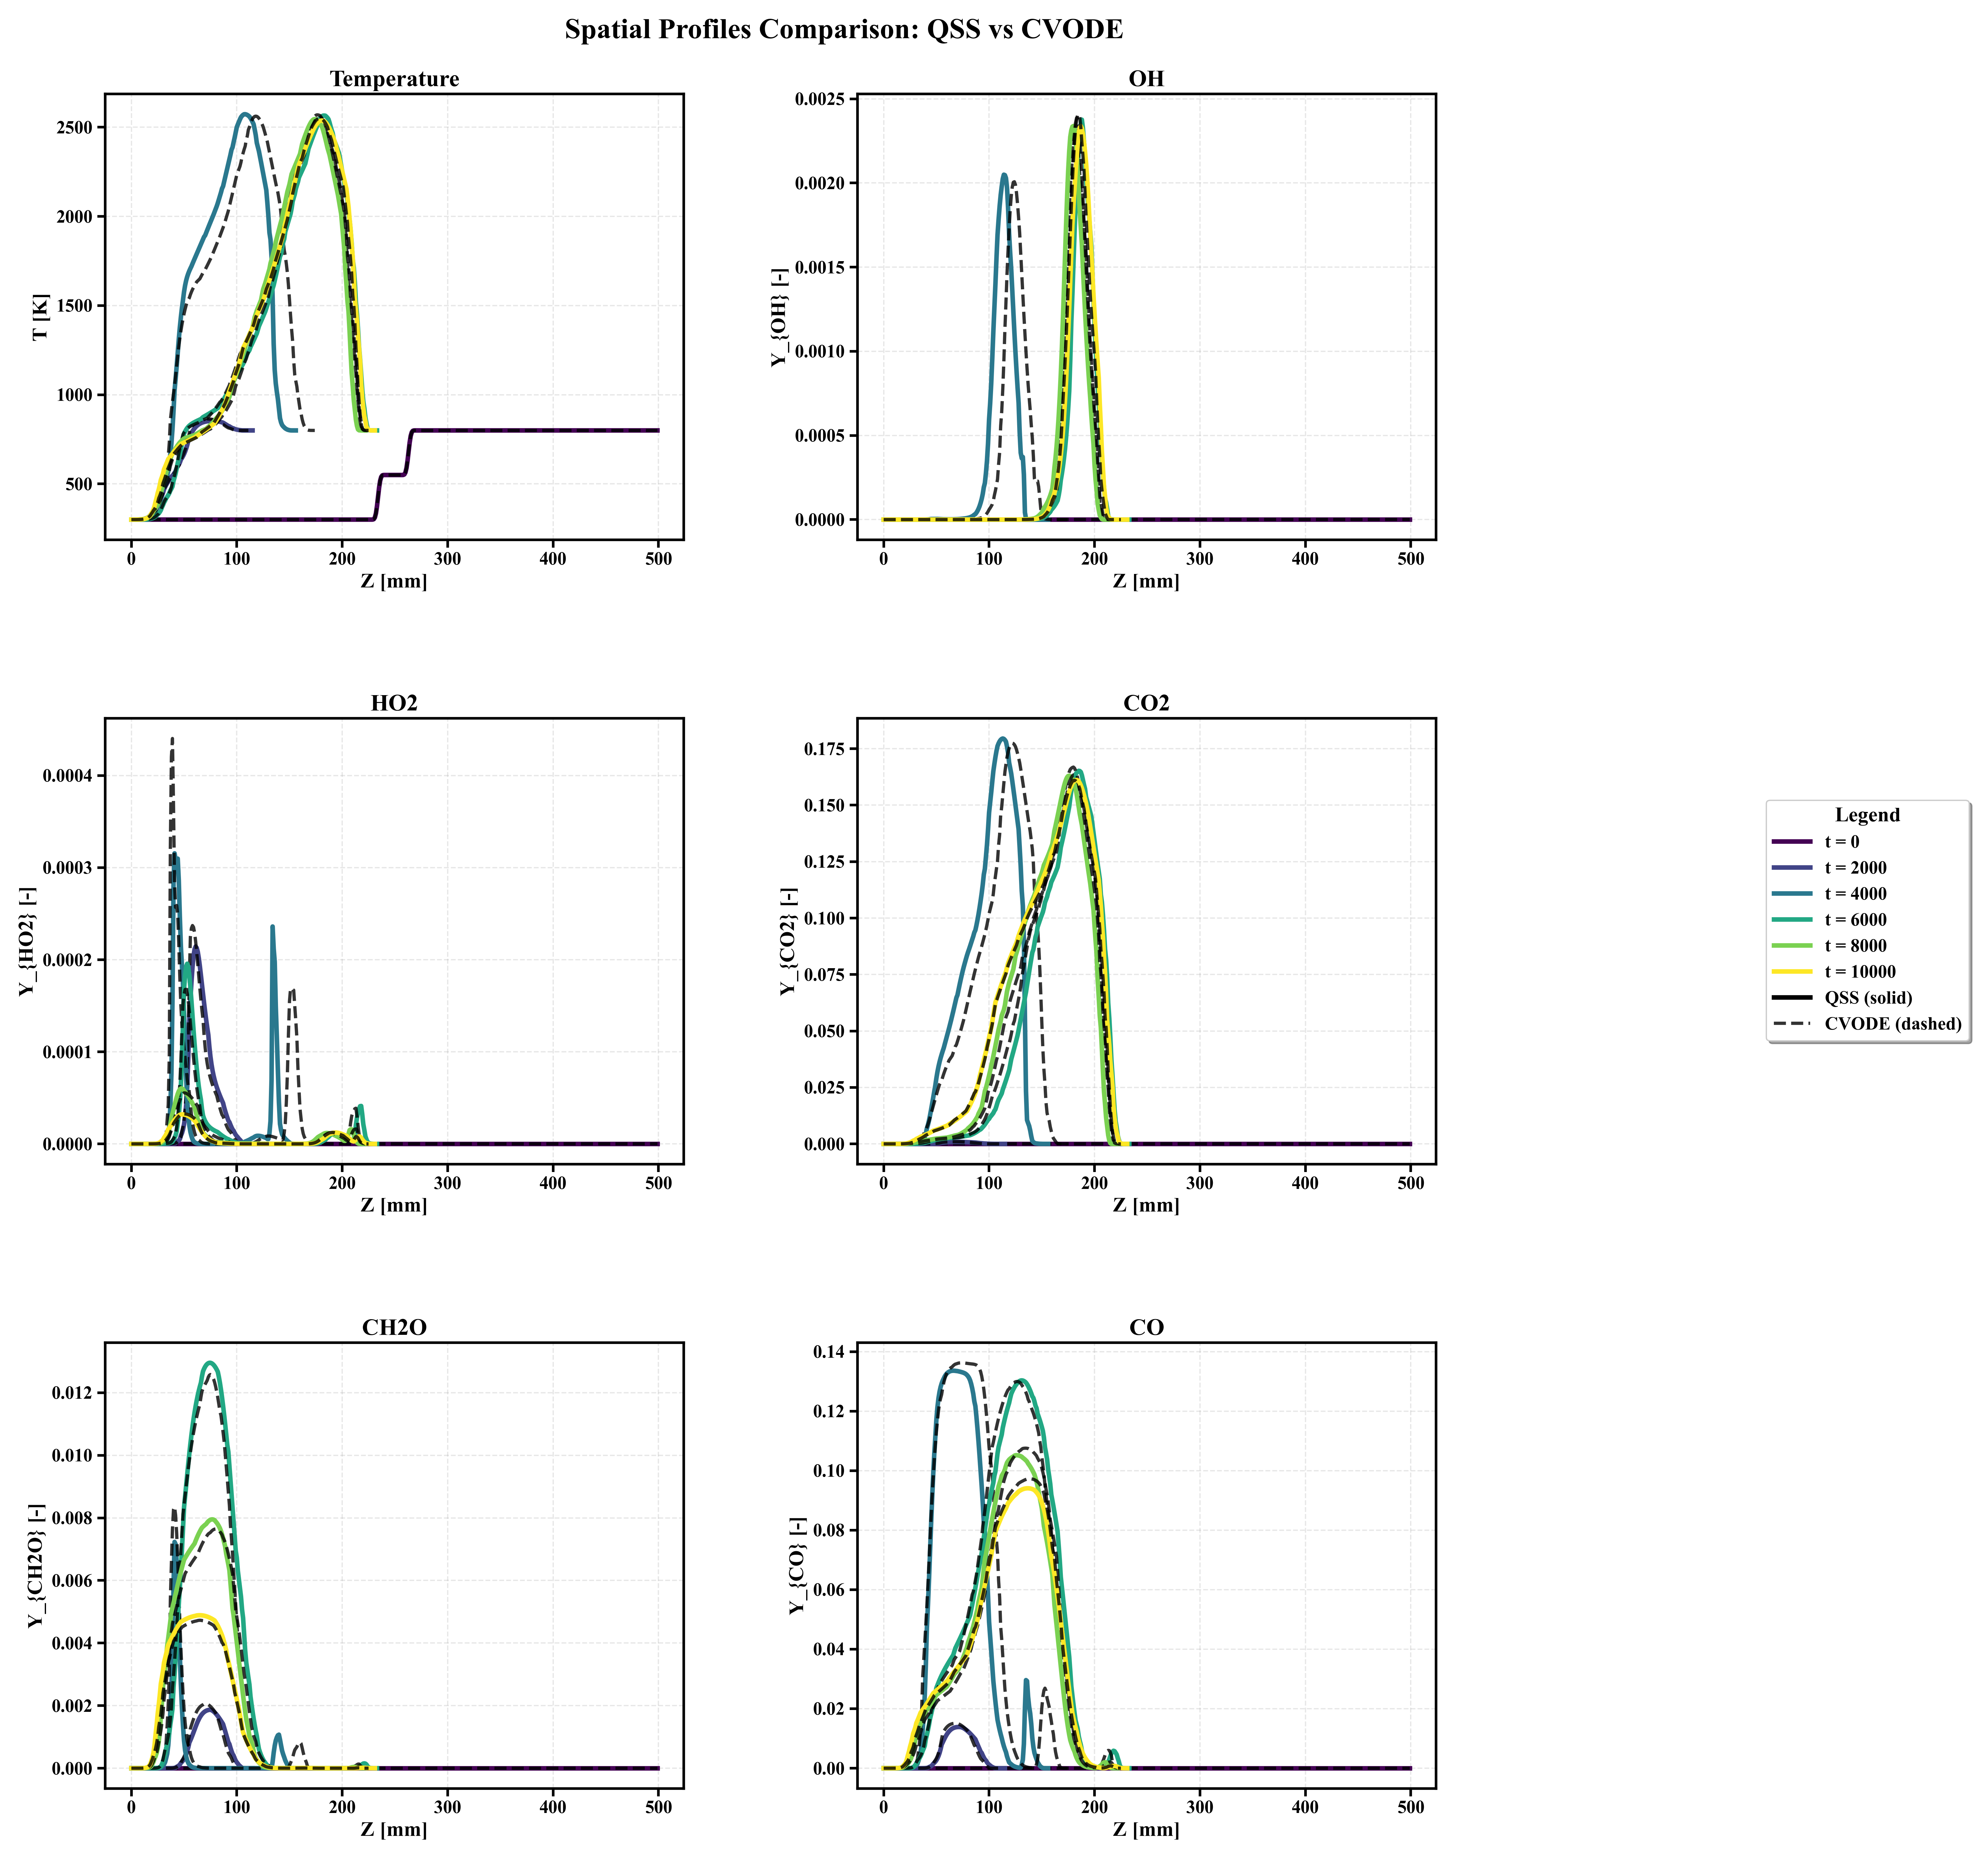


SPATIAL PROFILE COMPARISON: QSS vs CVODE
Timestep     Max ΔT (K)      Rel. Diff (%)      Max Species Diff    
--------------------------------------------------------------------------------
0            0.00            0.00               2.44e-56            


ValueError: operands could not be broadcast together with shapes (116,) (112,) 

In [154]:
plot_spatial_profiles(results, method='qss', domain_length=0.02, n_timesteps=6)

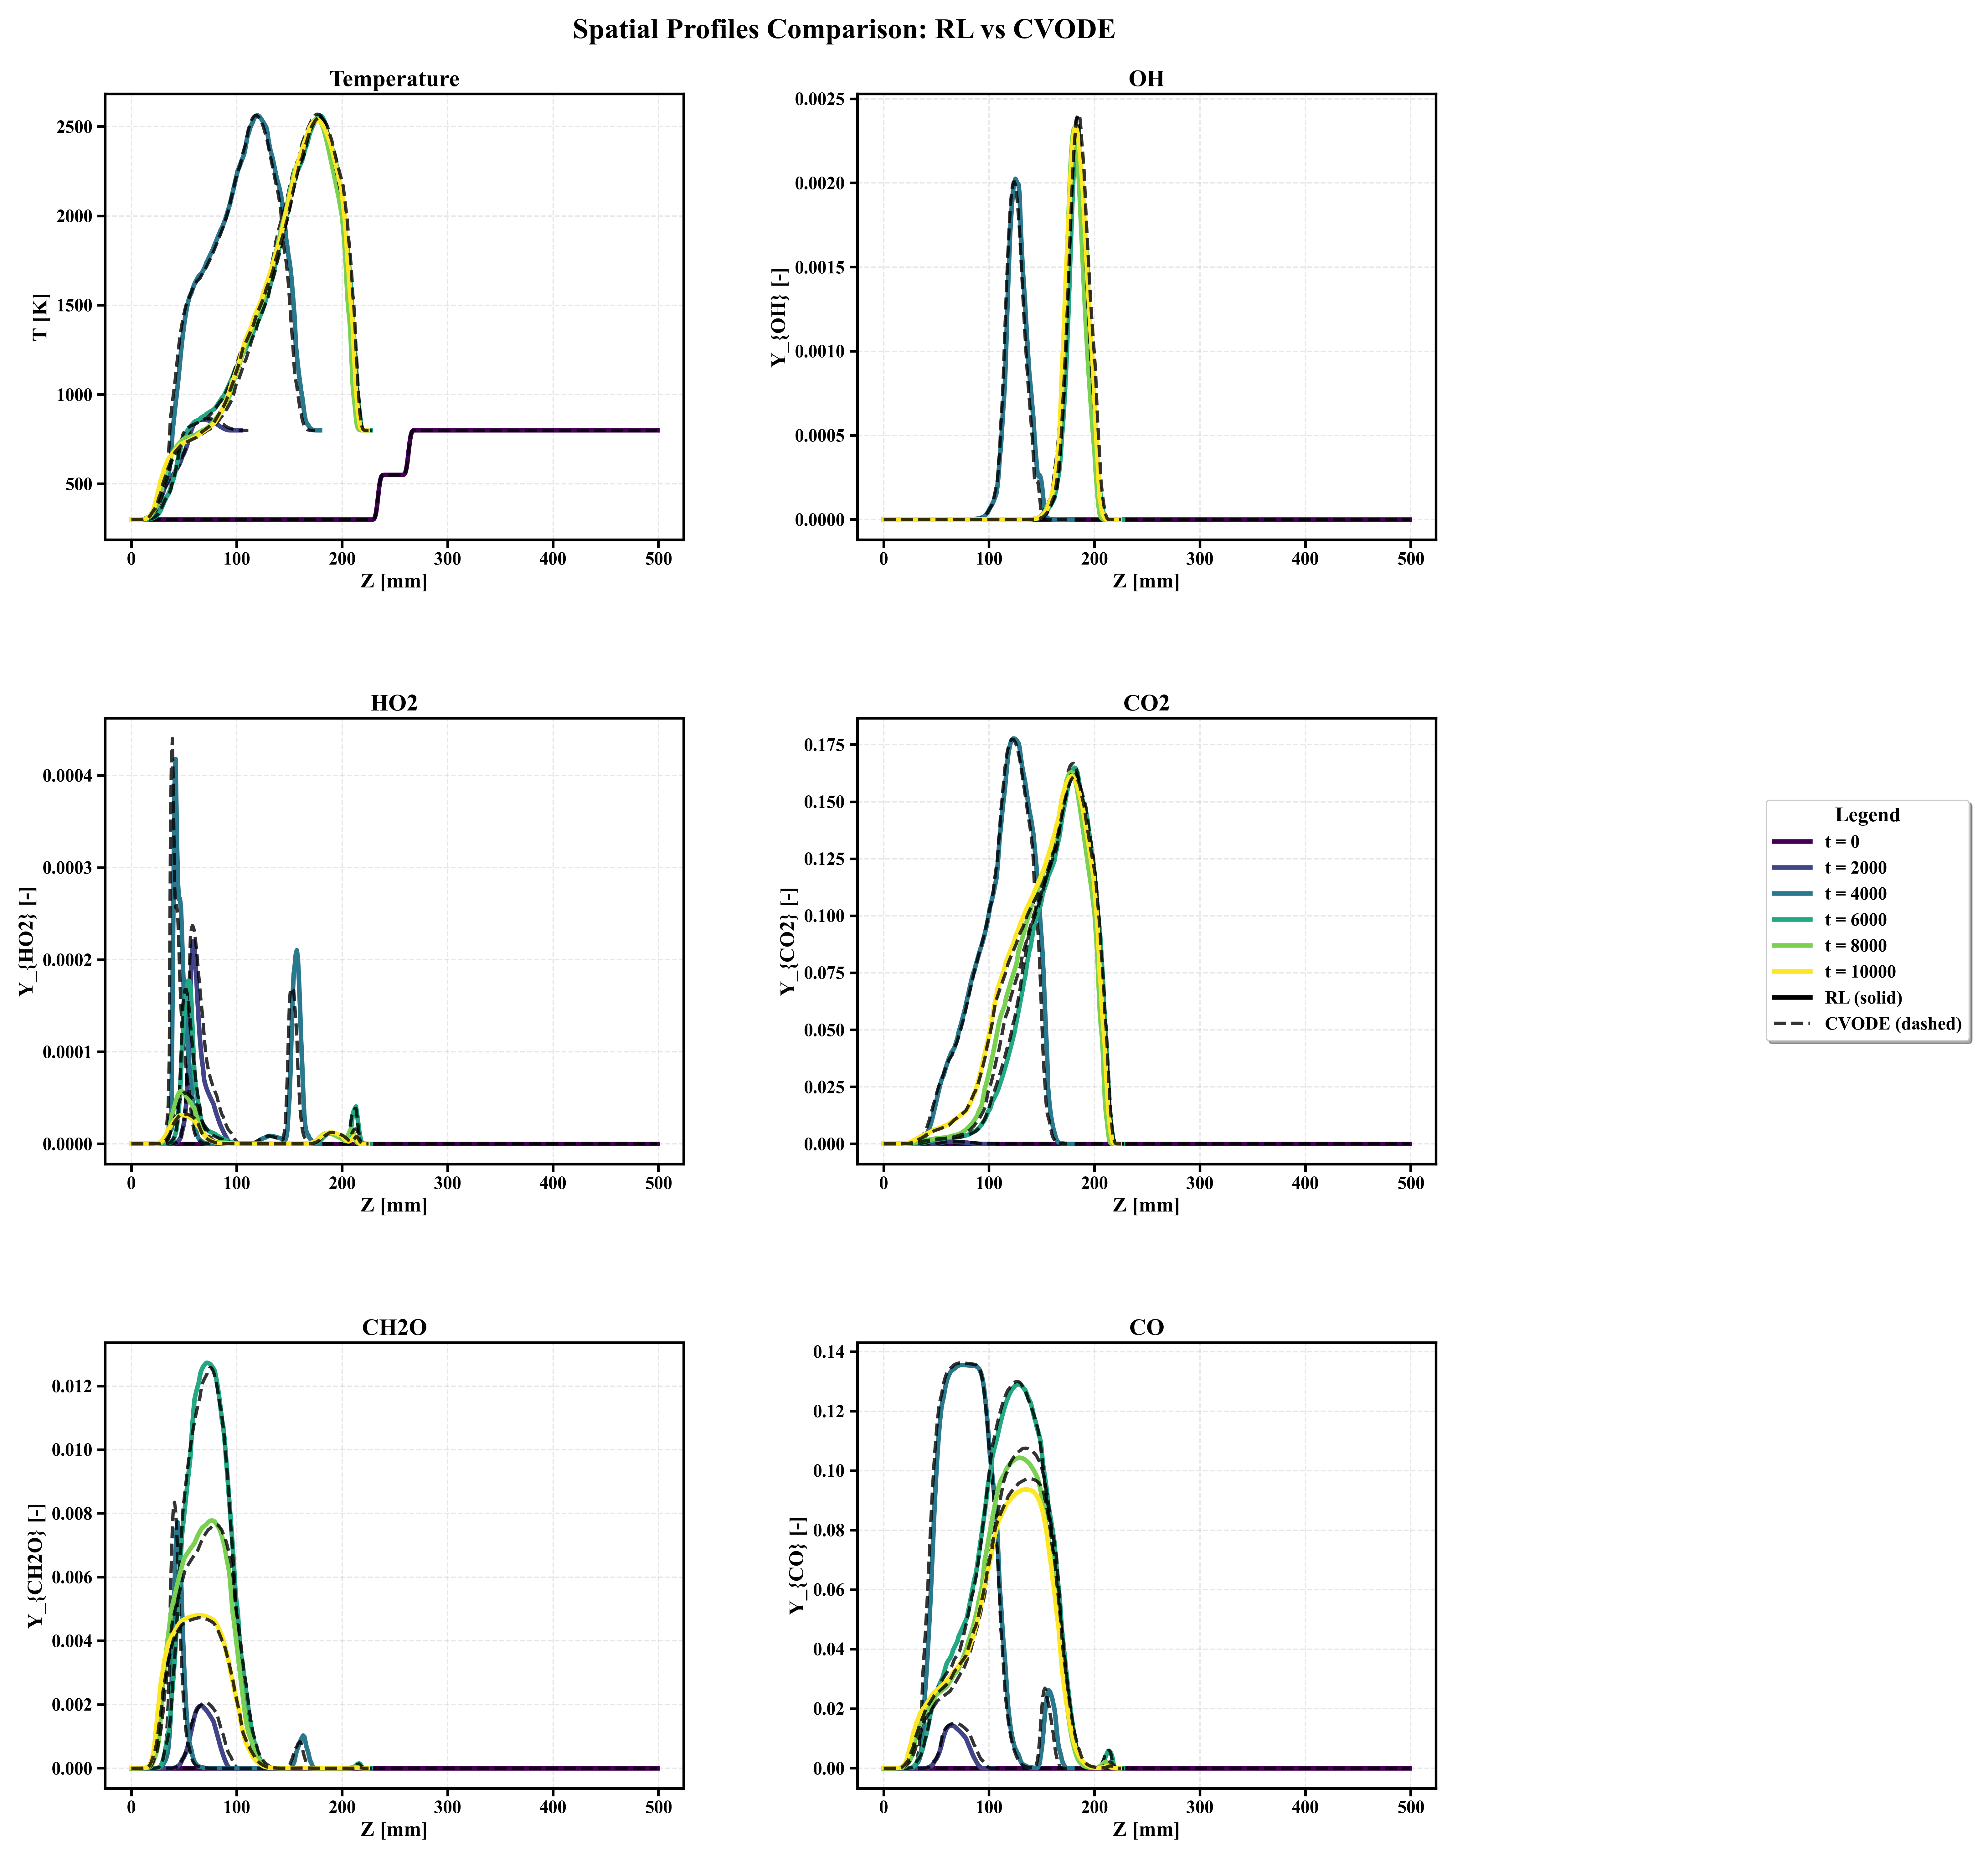


SPATIAL PROFILE COMPARISON: RL vs CVODE
Timestep     Max ΔT (K)      Rel. Diff (%)      Max Species Diff    
--------------------------------------------------------------------------------
0            0.00            0.00               2.44e-56            


ValueError: operands could not be broadcast together with shapes (105,) (112,) 

In [153]:
plot_spatial_profiles(results, method='rl', domain_length=0.02, n_timesteps=6)

In [47]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import cantera as ct
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.linewidth': 1.2,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'legend.title_fontsize': 10,
    'lines.linewidth': 2.0,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'figure.dpi': 100,  # Lower for animation efficiency
    'animation.writer': 'ffmpeg'
})

def animate_spatial_profiles(results, method='rl', domain_length=0.008, 
                           n_skip=10, fps=10, duration=None, save_path='spatial_animation.mp4'):
    """
    Create an animated plot of spatial profiles with integrator action highlighting
    
    Parameters:
    -----------
    results : dict
        Dictionary containing simulation results
    method : str
        Integration method to animate ('rl', 'qss', 'heuristic')
    domain_length : float
        Physical domain length in meters
    n_skip : int
        Skip every n timesteps for efficiency (default: 10)
    fps : int
        Frames per second for the animation
    duration : float
        Target duration in seconds (if None, uses all available frames)
    save_path : str
        Path to save the MP4 file
    """
    
    # Check if selected method exists
    if method not in results or results[method] is None:
        print(f"Results for method '{method}' not found")
        return
    
    # Check if CVODE exists for comparison
    if 'cvode' not in results or results['cvode'] is None:
        print("CVODE results not found for comparison")
        return
    
    # Extract data for both methods
    T_history_method = np.array(results[method]['T_history'])
    Y_history_method = np.array(results[method]['Y_history'])
    integrator_history_method = np.array(results[method]['integrator_history'])
    T_history_cvode = np.array(results['cvode']['T_history'])
    Y_history_cvode = np.array(results['cvode']['Y_history'])
    
    # Get dimensions
    n_time, n_grid = T_history_method.shape
    
    # Create spatial coordinate
    z = np.linspace(0, domain_length, n_grid)
    
    # Load mechanism to get species names
    try:
        gas = ct.Solution('large_mechanism/n-dodecane.yaml')
    except:
        print("Warning: Could not load mechanism file, using dummy species indices")
        gas = None
    
    # Species to plot
    species_to_plot = ['OH', 'HO2', 'CO2', 'CH2O', 'CO']
    species_indices = []
    for i, spec in enumerate(species_to_plot):
        if gas is not None:
            try:
                species_indices.append(gas.species_index(spec))
            except ValueError:
                print(f"Warning: Species {spec} not found, using index {i}")
                species_indices.append(i if i < Y_history_method.shape[2] else 0)
        else:
            species_indices.append(i if i < Y_history_method.shape[2] else 0)
    
    # Determine frames to animate
    time_indices = np.arange(0, n_time, n_skip)
    if duration is not None:
        max_frames = int(duration * fps)
        if len(time_indices) > max_frames:
            time_indices = time_indices[:max_frames]
    
    print(f"Creating animation with {len(time_indices)} frames at {fps} fps")
    
    # Create figure and subplots (3x2 layout)
    fig, axs = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f'Spatial Profiles Animation: {method.upper()} vs CVODE', 
                 fontsize=14, fontweight='bold')
    
    # Pre-calculate global min/max for consistent scaling
    plot_data = [
        ('Temperature', 'T [K]', None, T_history_method, T_history_cvode),
        ('OH', f'Y_{{OH}} [-]', 0, None, None),
        ('HO2', f'Y_{{HO2}} [-]', 1, None, None),
        ('CO2', f'Y_{{CO2}} [-]', 2, None, None),
        ('CH2O', f'Y_{{CH2O}} [-]', 3, None, None),
        ('CO', f'Y_{{CO}} [-]', 4, None, None)
    ]
    
    # Pre-calculate limits for consistent scaling
    y_limits = []
    for plot_idx, (title, ylabel, species_idx, T_method, T_cvode) in enumerate(plot_data):
        if title == 'Temperature':
            data_method = T_method
            data_cvode = T_cvode
        else:
            data_method = Y_history_method[:, :, species_indices[species_idx]]
            data_cvode = Y_history_cvode[:, :, species_indices[species_idx]]
        
        y_min = min(np.min(data_method), np.min(data_cvode))
        y_max = max(np.max(data_method), np.max(data_cvode))
        
        # Add margins
        if title != 'Temperature' and y_max < 1e-2:
            # Use log scale
            y_limits.append((max(y_min, 1e-8), y_max * 1.1))
        else:
            margin = (y_max - y_min) * 0.1
            y_limits.append((y_min - margin, y_max + margin))
    
    # Initialize empty line objects and scatter objects
    lines_method = []
    lines_cvode = []
    scatters = []
    
    # Setup subplots and initialize empty plots
    for plot_idx, (title, ylabel, species_idx, _, _) in enumerate(plot_data):
        row = plot_idx // 2
        col = plot_idx % 2
        ax = axs[row, col]
        
        # Initialize empty line objects
        line_method, = ax.plot([], [], color='blue', linewidth=2.5, 
                              linestyle='-', label=method.upper(), alpha=0.8)
        line_cvode, = ax.plot([], [], color='red', linewidth=2.0, 
                             linestyle='--', label='CVODE', alpha=0.7)
        
        # Initialize scatter for integrator actions (only for method, not CVODE)
        scatter = ax.scatter([], [], c=[], s=30, alpha=0.6, 
                            cmap=ListedColormap(['red', 'green']), 
                            vmin=0, vmax=1, zorder=10)
        
        lines_method.append(line_method)
        lines_cvode.append(line_cvode)
        scatters.append(scatter)
        
        # Setup axes
        ax.set_xlabel('Z [mm]')
        ax.set_ylabel(ylabel)
        ax.set_title(title, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, domain_length * 1000)
        ax.set_ylim(y_limits[plot_idx])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Set log scale for species if needed
        if title != 'Temperature' and y_limits[plot_idx][1] < 1e-2:
            ax.set_yscale('log')
        
        # Add legend only to first subplot
        if plot_idx == 0:
            legend_elements = [
                Line2D([0], [0], color='blue', linewidth=2.5, linestyle='-', 
                       label=method.upper()),
                Line2D([0], [0], color='red', linewidth=2.0, linestyle='--', 
                       label='CVODE'),
                mpatches.Patch(color='red', label='Action 0 (CVODE)'),
                mpatches.Patch(color='green', label='Action 1 (QSS)')
            ]
            ax.legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    # Add timestep text
    timestep_text = fig.text(0.02, 0.95, '', fontsize=12, fontweight='bold')
    
    def animate(frame_idx):
        """Animation function called for each frame"""
        time_idx = time_indices[frame_idx]
        
        # Update timestep text
        timestep_text.set_text(f'Timestep: {time_idx}')
        
        # Convert integrator actions to numeric (0 for cvode, 1 for qss)
        integrator_actions = integrator_history_method[time_idx, :]
        # Convert string actions to numeric
        if isinstance(integrator_actions[0], str):
            actions_numeric = np.where(integrator_actions == 'cvode', 0, 1)
        else:
            actions_numeric = integrator_actions.astype(int)
        
        artists = [timestep_text]
        
        # Update each subplot
        for plot_idx, (title, ylabel, species_idx, _, _) in enumerate(plot_data):
            if title == 'Temperature':
                profile_method = T_history_method[time_idx, :]
                profile_cvode = T_history_cvode[time_idx, :]
            else:
                profile_method = Y_history_method[time_idx, species_indices[species_idx], :]
                profile_cvode = Y_history_cvode[time_idx, species_indices[species_idx], :]
            
            # Update line data
            lines_method[plot_idx].set_data(z * 1000, profile_method)
            lines_cvode[plot_idx].set_data(z * 1000, profile_cvode)
            
            # Update scatter points for integrator actions
            # Only show scatter points where there are significant values to avoid clutter
            mask = profile_method > (np.max(profile_method) * 0.01) if title != 'Temperature' else np.ones_like(profile_method, dtype=bool)
            z_masked = z[mask] * 1000
            profile_masked = profile_method[mask]
            actions_masked = actions_numeric[mask]
            
            if len(z_masked) > 0:
                scatters[plot_idx].set_offsets(np.column_stack([z_masked, profile_masked]))
                scatters[plot_idx].set_array(actions_masked)
            else:
                scatters[plot_idx].set_offsets(np.empty((0, 2)))
                scatters[plot_idx].set_array(np.array([]))
            
            artists.extend([lines_method[plot_idx], lines_cvode[plot_idx], scatters[plot_idx]])
        
        return artists
    
    # Create animation
    print("Creating animation object...")
    anim = animation.FuncAnimation(fig, animate, frames=len(time_indices),
                                  interval=1000/fps, blit=True, repeat=True)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.3)
    
    # Save animation
    print(f"Saving animation to {save_path}...")
    try:
        # Use lower quality settings for faster rendering
        writer = animation.FFMpegWriter(fps=fps, metadata=dict(artist='Python'),
                                      bitrate=1800, extra_args=['-vcodec', 'libx264'])
        anim.save(save_path, writer=writer, dpi=80)
        print(f"Animation saved successfully to {save_path}")
    except Exception as e:
        print(f"Error saving animation: {e}")
        print("Trying alternative writer...")
        try:
            anim.save(save_path.replace('.mp4', '.gif'), writer='pillow', fps=fps//2, dpi=60)
            print(f"Animation saved as GIF: {save_path.replace('.mp4', '.gif')}")
        except Exception as e2:
            print(f"Could not save animation: {e2}")
    
    return anim, fig

def create_optimized_animation(results, method='rl', domain_length=0.008, 
                             target_duration=30, fps=15):
    """
    Create an optimized animation with automatic frame selection for target duration
    
    Parameters:
    -----------
    results : dict
        Dictionary containing simulation results  
    method : str
        Integration method to animate
    domain_length : float
        Physical domain length in meters
    target_duration : float
        Target animation duration in seconds
    fps : int
        Frames per second
    """
    
    # Calculate optimal skip rate
    n_time = len(results[method]['T_history'])
    target_frames = target_duration * fps
    n_skip = max(1, n_time // target_frames)
    
    print(f"Optimizing for {target_duration}s at {fps} fps:")
    print(f"Total timesteps: {n_time}")
    print(f"Skip rate: {n_skip}")
    print(f"Final frames: {n_time // n_skip}")
    print(f"Actual duration: {(n_time // n_skip) / fps:.1f}s")
    
    return animate_spatial_profiles(results, method=method, 
                                  domain_length=domain_length,
                                  n_skip=n_skip, fps=fps, 
                                  save_path=f'spatial_animation_{method}_optimized.mp4')



Optimizing for 30s at 15 fps:
Total timesteps: 5001
Skip rate: 11
Final frames: 454
Actual duration: 30.3s
Creating animation with 455 frames at 15 fps
Creating animation object...
Saving animation to spatial_animation_rl_optimized.mp4...
Animation saved successfully to spatial_animation_rl_optimized.mp4


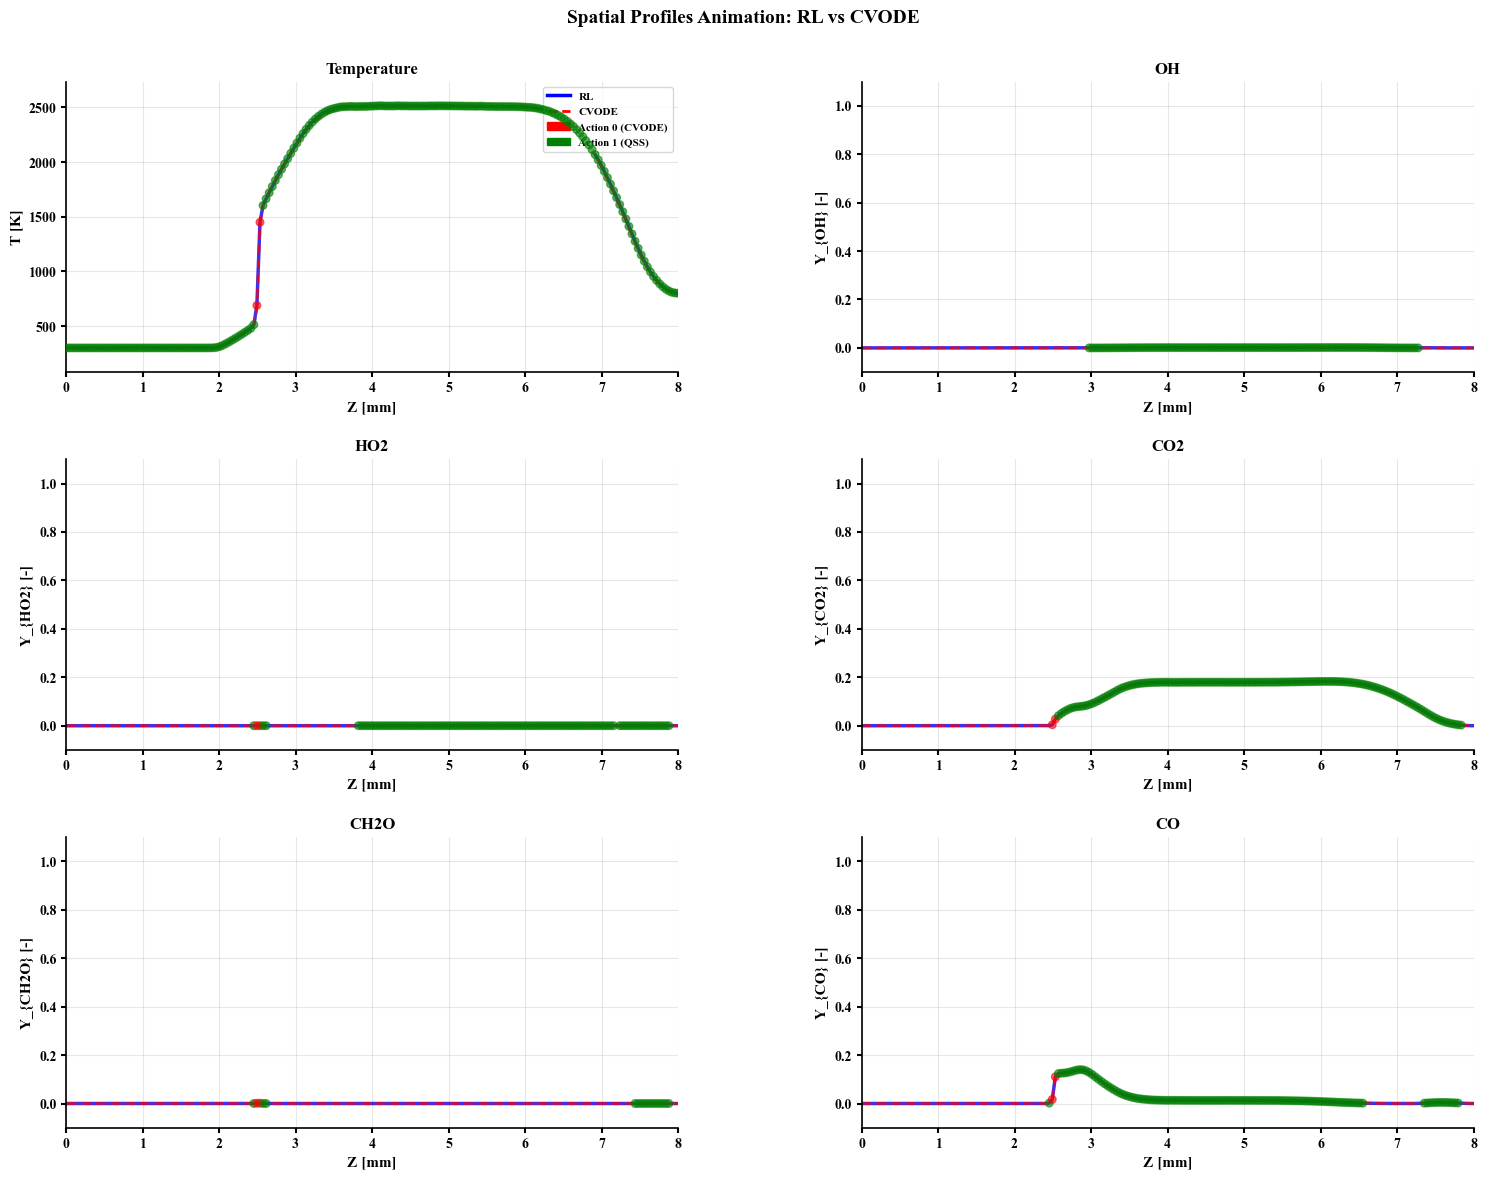

In [48]:
# Example usage:
# Create optimized 30-second animation at 15 fps
anim, fig = create_optimized_animation(results, method='rl', target_duration=30, fps=15)

# Or create custom animation with specific parameters
# anim, fig = animate_spatial_profiles(results, method='qss', n_skip=5, fps=12)

Optimizing for 10s at 15 fps:
Total timesteps: 5001
Skip rate: 33
Final frames: 151
Actual duration: 10.1s
Creating animation with 152 frames at 15 fps
y_min: 299.9999999954278, y_max: 2515.531144477642
y_min: 0.0, y_max: 0.0027728220927123
OH: [(np.float64(78.44688554720636), np.float64(2737.0842589258637)), (0, np.float64(0.00305010430198353))]
y_min: 0.0, y_max: 0.0008114001337257251
HO2: [(np.float64(78.44688554720636), np.float64(2737.0842589258637)), (0, np.float64(0.00305010430198353)), (0, np.float64(0.0008925401470982977))]
y_min: 0.0, y_max: 0.18295728326842048
CO2: [(np.float64(78.44688554720636), np.float64(2737.0842589258637)), (0, np.float64(0.00305010430198353)), (0, np.float64(0.0008925401470982977)), (0, np.float64(0.20125301159526252))]
y_min: 0.0, y_max: 0.00922782171609714
CH2O: [(np.float64(78.44688554720636), np.float64(2737.0842589258637)), (0, np.float64(0.00305010430198353)), (0, np.float64(0.0008925401470982977)), (0, np.float64(0.20125301159526252)), (0, np.f

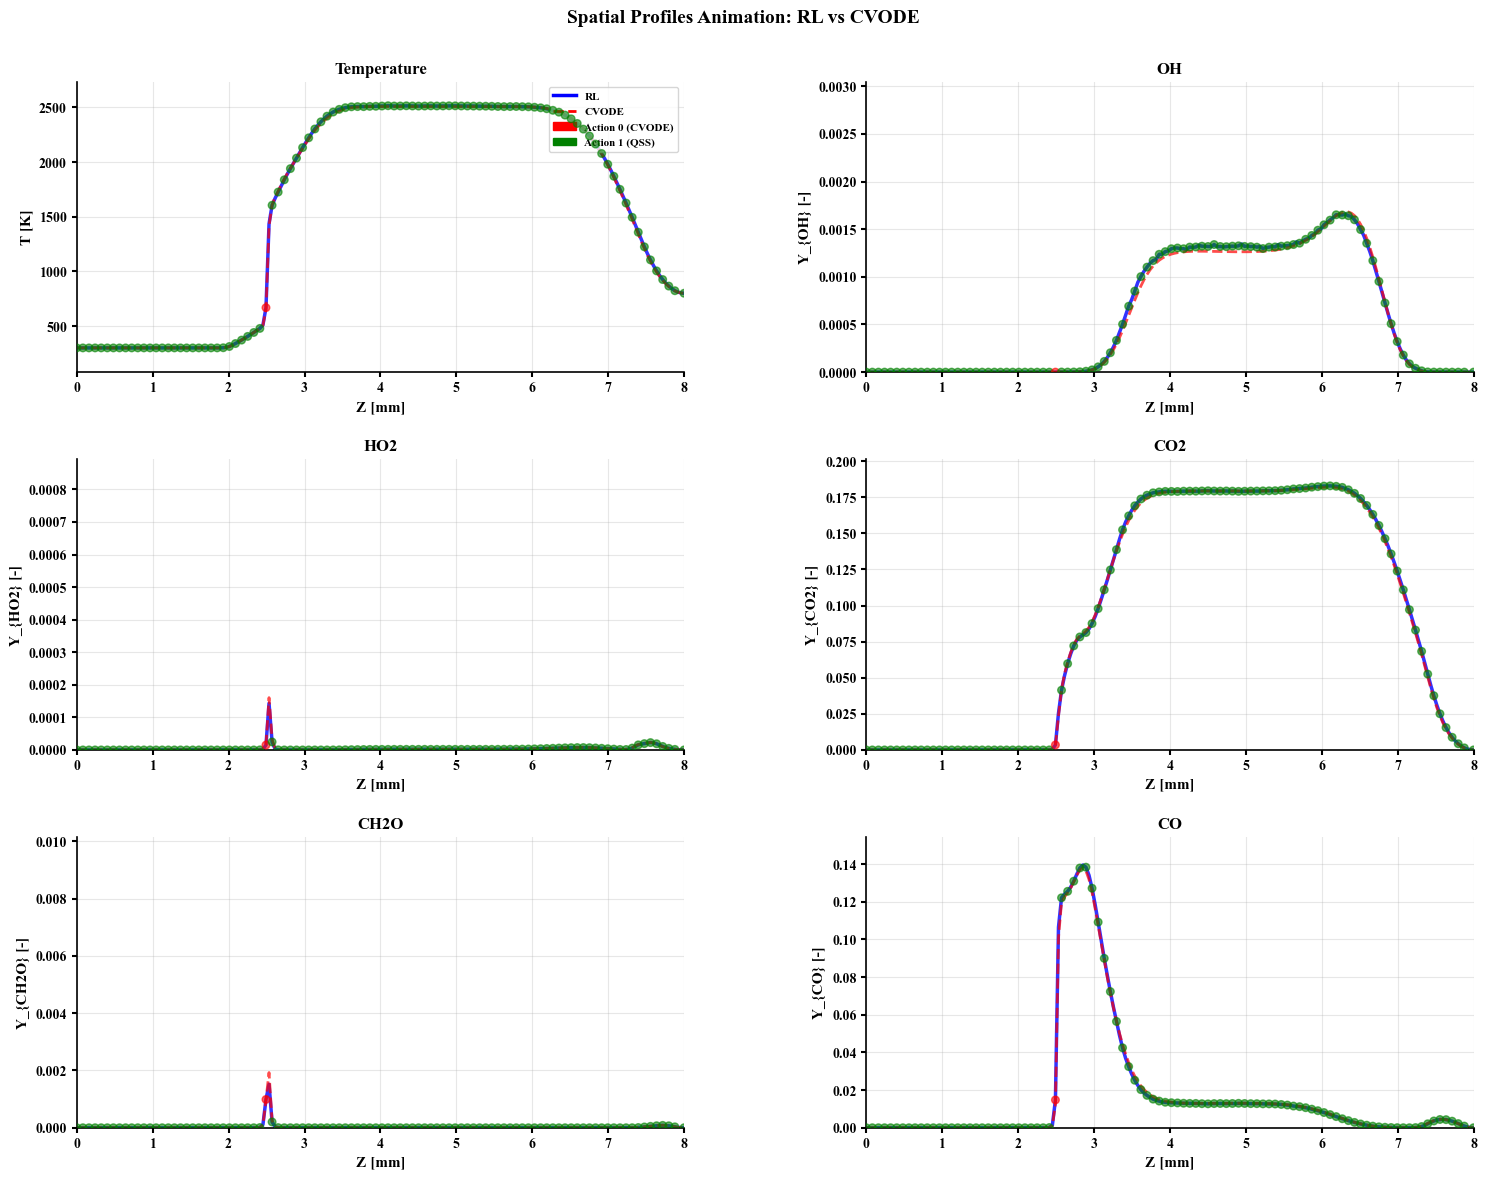

In [54]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import cantera as ct
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.linewidth': 1.2,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'legend.title_fontsize': 10,
    'lines.linewidth': 2.0,
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'figure.dpi': 100,  # Lower for animation efficiency
    'animation.writer': 'ffmpeg'
})

def animate_spatial_profiles(results, method='rl', domain_length=0.008, 
                           n_skip=10, fps=10, duration=None, save_path='spatial_animation.mp4'):
    """
    Create an animated plot of spatial profiles with integrator action highlighting
    
    Parameters:
    -----------
    results : dict
        Dictionary containing simulation results
    method : str
        Integration method to animate ('rl', 'qss', 'heuristic')
    domain_length : float
        Physical domain length in meters
    n_skip : int
        Skip every n timesteps for efficiency (default: 10)
    fps : int
        Frames per second for the animation
    duration : float
        Target duration in seconds (if None, uses all available frames)
    save_path : str
        Path to save the MP4 file
    """
    
    # Check if selected method exists
    if method not in results or results[method] is None:
        print(f"Results for method '{method}' not found")
        return
    
    # Check if CVODE exists for comparison
    if 'cvode' not in results or results['cvode'] is None:
        print("CVODE results not found for comparison")
        return
    
    # Extract data for both methods
    T_history_method = np.array(results[method]['T_history'])
    Y_history_method = np.array(results[method]['Y_history'])
    integrator_history_method = np.array(results[method]['integrator_history'])
    T_history_cvode = np.array(results['cvode']['T_history'])
    Y_history_cvode = np.array(results['cvode']['Y_history'])
    
    # Get dimensions
    n_time, n_grid = T_history_method.shape
    
    # Create spatial coordinate
    z = np.linspace(0, domain_length, n_grid)
    
    # Load mechanism to get species names
    try:
        gas = ct.Solution('large_mechanism/n-dodecane.yaml')
    except:
        print("Warning: Could not load mechanism file, using dummy species indices")
        gas = None
    
    # Species to plot
    species_to_plot = ['OH', 'HO2', 'CO2', 'CH2O', 'CO']
    species_indices = []
    for i, spec in enumerate(species_to_plot):
        if gas is not None:
            try:
                species_indices.append(gas.species_index(spec))
            except ValueError:
                print(f"Warning: Species {spec} not found, using index {i}")
                species_indices.append(i if i < Y_history_method.shape[2] else 0)
        else:
            species_indices.append(i if i < Y_history_method.shape[2] else 0)
    
    # Determine frames to animate
    time_indices = np.arange(0, n_time, n_skip)
    if duration is not None:
        max_frames = int(duration * fps)
        if len(time_indices) > max_frames:
            time_indices = time_indices[:max_frames]
    
    print(f"Creating animation with {len(time_indices)} frames at {fps} fps")
    
    # Create figure and subplots (3x2 layout)
    fig, axs = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f'Spatial Profiles Animation: {method.upper()} vs CVODE', 
                 fontsize=14, fontweight='bold')
    
    # Pre-calculate global min/max for consistent scaling
    plot_data = [
        ('Temperature', 'T [K]', None, T_history_method, T_history_cvode),
        ('OH', f'Y_{{OH}} [-]', 0, None, None),
        ('HO2', f'Y_{{HO2}} [-]', 1, None, None),
        ('CO2', f'Y_{{CO2}} [-]', 2, None, None),
        ('CH2O', f'Y_{{CH2O}} [-]', 3, None, None),
        ('CO', f'Y_{{CO}} [-]', 4, None, None)
    ]
    
    # Pre-calculate limits for consistent scaling
    y_limits = []
    for plot_idx, (title, ylabel, species_idx, T_method, T_cvode) in enumerate(plot_data):
        if title == 'Temperature':
            data_method = T_method
            data_cvode = T_cvode
        else:
            data_method = Y_history_method[:, species_indices[species_idx], :]
            data_cvode = Y_history_cvode[:, species_indices[species_idx], :]
        
        y_min = min(np.min(data_method), np.min(data_cvode))
        y_max = max(np.max(data_method), np.max(data_cvode))
        print(f"y_min: {y_min}, y_max: {y_max}")
        # Add margins - use actual max values for species
        if title != 'Temperature':
            # if y_max < 1e-6:
            #     # Very small values - use log scale with tight bounds
            #     y_limits.append((max(y_min, 1e-10), y_max * 2))
            # else:
            #     # Use linear scale with proper max value
            margin = y_max * 0.1  # 10% margin above max
            y_limits.append((max(0, y_min - margin*0.1), y_max + margin))
            print(f"{title}: {y_limits}")
        else:
            # Temperature - use linear scale
            margin = (y_max - y_min) * 0.1
            y_limits.append((y_min - margin, y_max + margin))
    
    # Initialize empty line objects and scatter objects
    lines_method = []
    lines_cvode = []
    scatters = []
    
    # Setup subplots and initialize empty plots
    for plot_idx, (title, ylabel, species_idx, _, _) in enumerate(plot_data):
        row = plot_idx // 2
        col = plot_idx % 2
        ax = axs[row, col]
        
        # Initialize empty line objects
        line_method, = ax.plot([], [], color='blue', linewidth=2.5, 
                              linestyle='-', label=method.upper(), alpha=0.8)
        line_cvode, = ax.plot([], [], color='red', linewidth=2.0, 
                             linestyle='--', label='CVODE', alpha=0.7)
        
        # Initialize scatter for integrator actions (only for method, not CVODE)
        scatter = ax.scatter([], [], c=[], s=30, alpha=0.6, 
                            cmap=ListedColormap(['red', 'green']), 
                            vmin=0, vmax=1, zorder=10)
        
        lines_method.append(line_method)
        lines_cvode.append(line_cvode)
        scatters.append(scatter)
        
        # Setup axes
        ax.set_xlabel('Z [mm]')
        ax.set_ylabel(ylabel)
        ax.set_title(title, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, domain_length * 1000)
        print(y_limits[plot_idx])
        ax.set_ylim(y_limits[plot_idx])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Set log scale for species if needed
        # if title != 'Temperature' and y_limits[plot_idx][1] < 1e-6:
        #     ax.set_yscale('log')
        # else:
        #     ax.set_yscale('linear')
        
        # Add legend only to first subplot
        if plot_idx == 0:
            legend_elements = [
                Line2D([0], [0], color='blue', linewidth=2.5, linestyle='-', 
                       label=method.upper()),
                Line2D([0], [0], color='red', linewidth=2.0, linestyle='--', 
                       label='CVODE'),
                mpatches.Patch(color='red', label='Action 0 (CVODE)'),
                mpatches.Patch(color='green', label='Action 1 (QSS)')
            ]
            ax.legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    # Add timestep text
    timestep_text = fig.text(0.02, 0.95, '', fontsize=12, fontweight='bold')
    
    def animate(frame_idx):
        """Animation function called for each frame"""
        time_idx = time_indices[frame_idx]
        
        # Update timestep text
        timestep_text.set_text(f'Timestep: {time_idx}')
        
        # Convert integrator actions to numeric (0 for cvode, 1 for qss)
        integrator_actions = integrator_history_method[time_idx, :]
        # Convert string actions to numeric
        if isinstance(integrator_actions[0], str):
            actions_numeric = np.where(integrator_actions == 'cvode', 0, 1)
        else:
            actions_numeric = integrator_actions.astype(int)
        
        artists = [timestep_text]
        
        # Update each subplot
        for plot_idx, (title, ylabel, species_idx, _, _) in enumerate(plot_data):
            if title == 'Temperature':
                profile_method = T_history_method[time_idx, :]
                profile_cvode = T_history_cvode[time_idx, :]
            else:
                profile_method = Y_history_method[time_idx, species_indices[species_idx], :]
                profile_cvode = Y_history_cvode[time_idx, species_indices[species_idx], :]
            
            # Update line data
            lines_method[plot_idx].set_data(z * 1000, profile_method)
            lines_cvode[plot_idx].set_data(z * 1000, profile_cvode)
            
            # Update scatter points for integrator actions
            # Show scatter points at regular intervals along the spatial domain for clear visualization
            n_scatter_points = min(100, n_grid)  # Limit to 20 points for clarity
            scatter_indices = np.linspace(0, n_grid-1, n_scatter_points, dtype=int)
            
            z_scatter = z[scatter_indices] * 1000
            profile_scatter = profile_method[scatter_indices]
            actions_scatter = actions_numeric[scatter_indices]
            
            scatters[plot_idx].set_offsets(np.column_stack([z_scatter, profile_scatter]))
            scatters[plot_idx].set_array(actions_scatter)
            
            artists.extend([lines_method[plot_idx], lines_cvode[plot_idx], scatters[plot_idx]])
        
        return artists
    
    # Create animation
    print("Creating animation object...")
    anim = animation.FuncAnimation(fig, animate, frames=len(time_indices),
                                  interval=1000/fps, blit=True, repeat=True)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.3)
    
    # Save animation
    print(f"Saving animation to {save_path}...")
    try:
        # Use lower quality settings for faster rendering
        writer = animation.FFMpegWriter(fps=fps, metadata=dict(artist='Python'),
                                      bitrate=1800, extra_args=['-vcodec', 'libx264'])
        anim.save(save_path, writer=writer, dpi=80)
        print(f"Animation saved successfully to {save_path}")
    except Exception as e:
        print(f"Error saving animation: {e}")
        print("Trying alternative writer...")
        try:
            anim.save(save_path.replace('.mp4', '.gif'), writer='pillow', fps=fps//2, dpi=60)
            print(f"Animation saved as GIF: {save_path.replace('.mp4', '.gif')}")
        except Exception as e2:
            print(f"Could not save animation: {e2}")
    
    return anim, fig

def create_optimized_animation(results, method='rl', domain_length=0.008, 
                             target_duration=30, fps=15):
    """
    Create an optimized animation with automatic frame selection for target duration
    
    Parameters:
    -----------
    results : dict
        Dictionary containing simulation results  
    method : str
        Integration method to animate
    domain_length : float
        Physical domain length in meters
    target_duration : float
        Target animation duration in seconds
    fps : int
        Frames per second
    """
    
    # Calculate optimal skip rate
    n_time = len(results[method]['T_history'])
    target_frames = target_duration * fps
    n_skip = max(1, n_time // target_frames)
    
    print(f"Optimizing for {target_duration}s at {fps} fps:")
    print(f"Total timesteps: {n_time}")
    print(f"Skip rate: {n_skip}")
    print(f"Final frames: {n_time // n_skip}")
    print(f"Actual duration: {(n_time // n_skip) / fps:.1f}s")
    
    return animate_spatial_profiles(results, method=method, 
                                  domain_length=domain_length,
                                  n_skip=n_skip, fps=fps, 
                                  save_path=f'spatial_animation_{method}_optimized.mp4')

# Example usage:
# Create optimized 30-second animation at 15 fps
anim, fig = create_optimized_animation(results, method='rl', target_duration=10, fps=15)

# Or create custom animation with specific parameters
# anim, fig = animate_spatial_profiles(results, method='qss', n_skip=5, fps=12)

In [95]:
from pathlib import Path
import cantera as ct
import matplotlib.pyplot as plt

In [96]:
p = ct.one_atm * 60 # pressure
tin_f = 300.0  # fuel inlet temperature
tin_o = 800.0  # oxidizer inlet temperature
mdot_o = 0.72  # kg/m^2/s
mdot_f = 0.24  # kg/m^2/s

comp_o = 'O2:1.0, N2:3.76'  # air composition
comp_f = 'nc12h26:1.0'  # fuel composition

width = 0.02  # Distance between inlets is 2 cm

loglevel = 1  # amount of diagnostic output (0 to 5)

In [97]:
# Create the gas object used to evaluate all thermodynamic, kinetic, and
# transport properties.
gas = ct.Solution('large_mechanism/n-dodecane.yaml')
gas.TP = gas.T, p

# Create an object representing the counterflow flame configuration,
# which consists of a fuel inlet on the left, the flow in the middle,
# and the oxidizer inlet on the right.
f = ct.CounterflowDiffusionFlame(gas, width=width)

# Set the state of the two inlets
f.fuel_inlet.mdot = mdot_f
f.fuel_inlet.X = comp_f
f.fuel_inlet.T = tin_f

f.oxidizer_inlet.mdot = mdot_o
f.oxidizer_inlet.X = comp_o
f.oxidizer_inlet.T = tin_o

# Set the boundary emissivities
f.boundary_emissivities = 0.0, 0.0
# Turn radiation off
f.radiation_enabled = False

f.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)

In [98]:
0.2/5e-6

40000.0

In [99]:
f.solve(loglevel, auto=True)


************ Solving on 6 point grid with energy equation enabled ************

..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 7.416e-08  log(ss)= 7.968     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 1.901e-06  log(ss)= 6.974     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 4.871e-05  log(ss)= 5.239     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.001873   log(ss)= 3.883     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.01422    log(ss)= 3.466     

Attempt Newton solution 

In [100]:
f.show_stats()


Statistics:

 Grid   Timesteps  Functions      Time  Jacobians      Time
    8           0       1522    0.3200         56    1.4012
   13         110       3356    1.3792        121    6.1857
   18         100       2611    1.5953        108    8.4632
   25         170       3880    3.5111        170   19.6373
   35          40        791    1.0608         30    5.0788
   49          30        601    1.1590         22    5.4900
   72           0        123    0.3511          5    1.8735
   92           0         18    0.0659          1    0.4705
   98           0          6    0.0236          1    0.5029


In [103]:
len(f.grid)

96

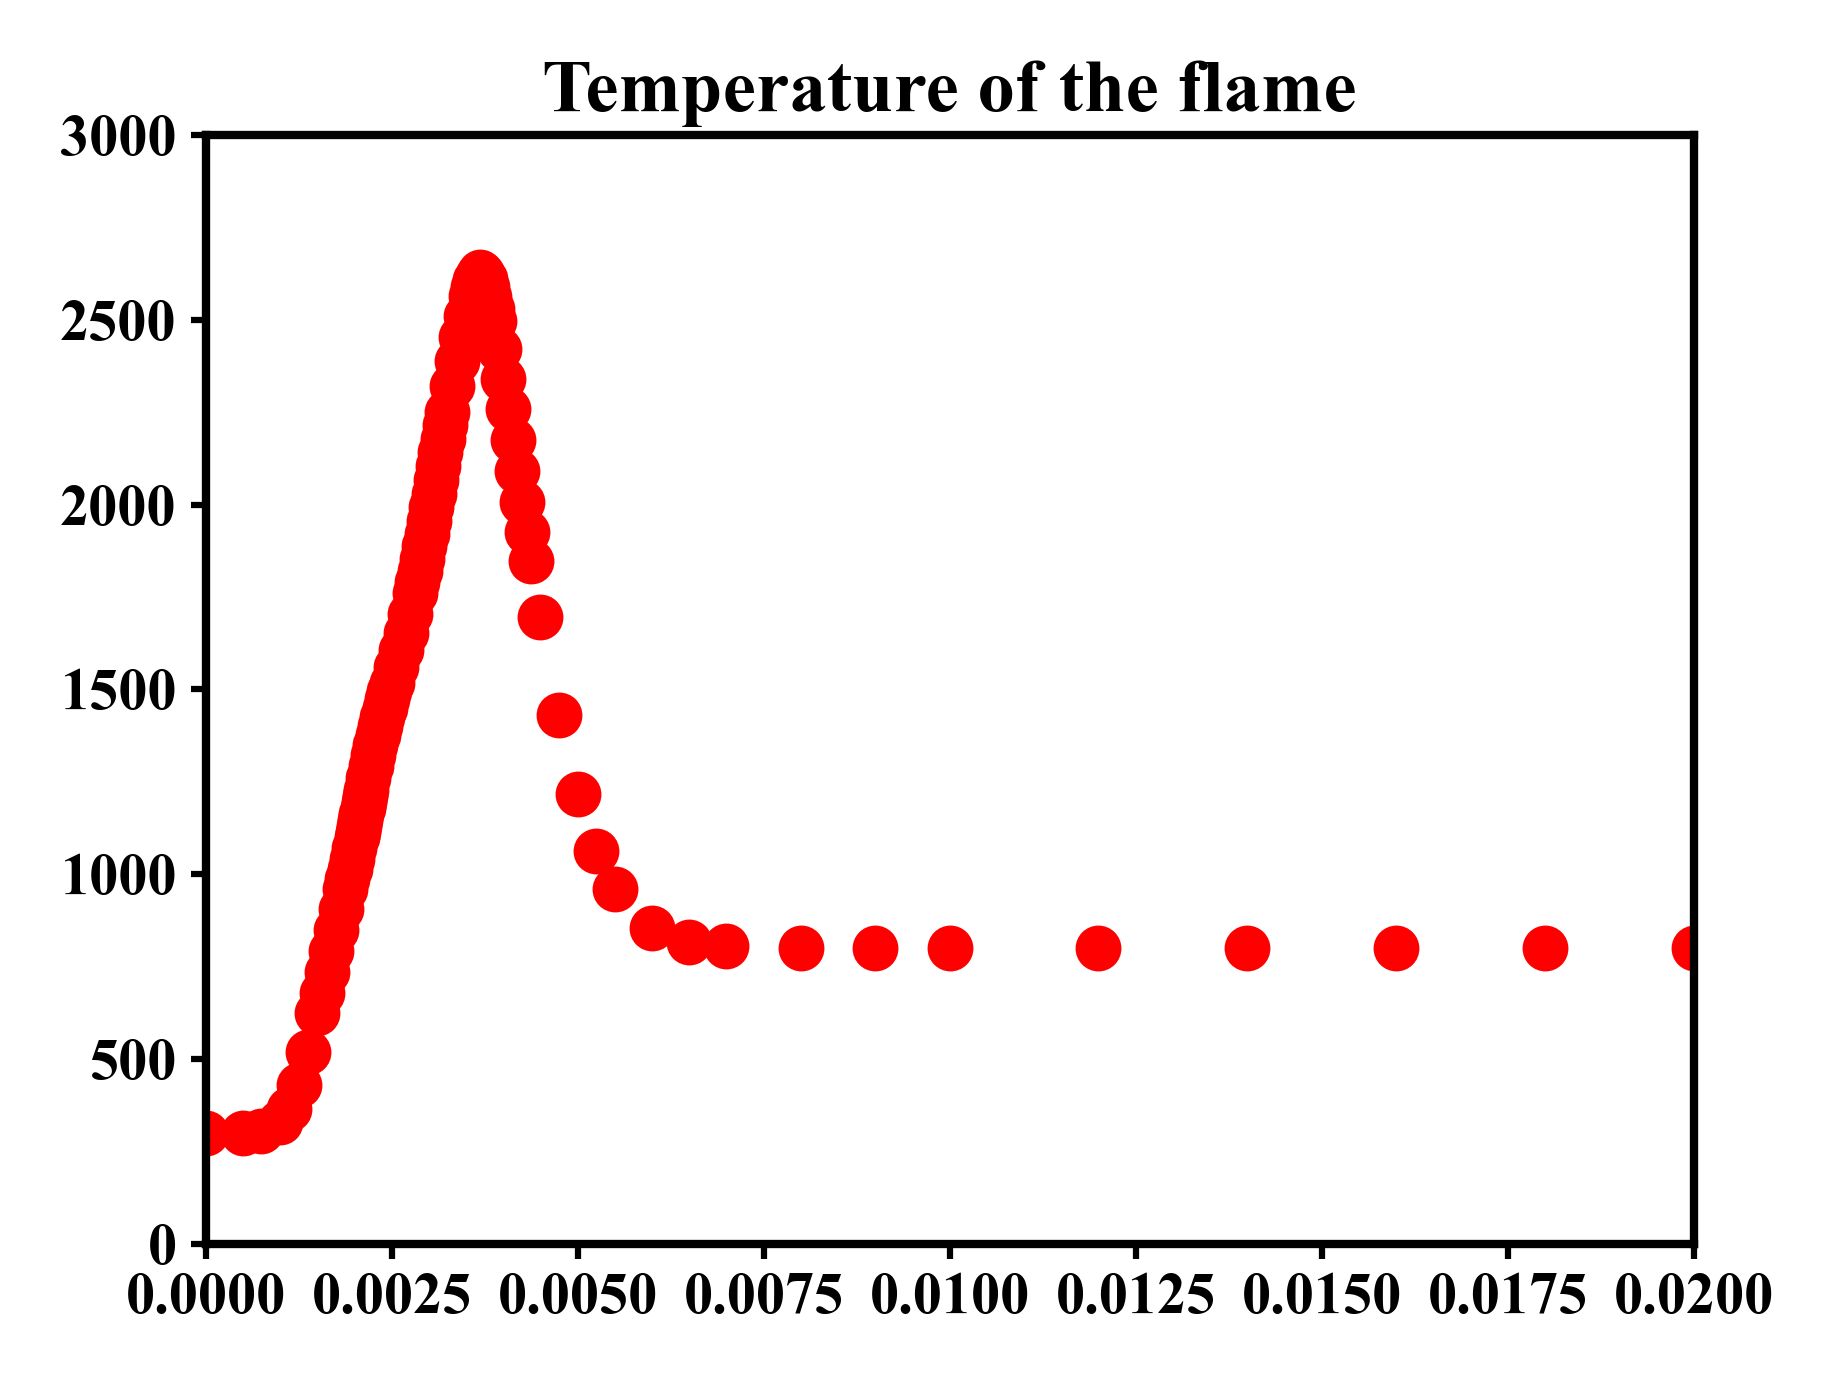

In [104]:
no_rad = f.to_array()
fig, ax = plt.subplots()
# ax.plot(no_rad.grid, no_rad.T, label='Temperature without radiation')
plt.plot(f.grid, f.T, 'ro')
ax.set_title('Temperature of the flame')
ax.set(ylim=(0,3000), xlim=(0.000, 0.020))
# ax.legend()
fig.savefig('./diffusion_flame.pdf')
plt.show()